##### Copyright 2020 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title ##### Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Sequential Monte Carlo (Particle filter) in TFP

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/main/tensorflow_probability/python/experimental/mcmc/examples/smc_demo.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/main/tensorflow_probability/python/experimental/mcmc/examples/smc_demo.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

### Dependencies & Prerequisites



In [0]:
# !pip3 install -q git+git://github.com/arviz-devs/arviz.git
# !pip3 install -q tf-nightly-gpu tfp-nightly

In [0]:
#@title Imports and setups
dark_mode = False #@param {type:"boolean"}
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import arviz as az

import tensorflow.compat.v1 as tf1
import tensorflow.compat.v2 as tf

import tensorflow_probability as tfp
from tensorflow_probability.python.internal import prefer_static as ps
from tensorflow_probability.python.mcmc.internal import util as mcmc_util
from tensorflow_probability.python.mcmc.transformed_kernel import (
    make_transform_fn, make_transformed_log_prob)

tfd = tfp.distributions
tfb = tfp.bijectors

tf.enable_v2_behavior()

sns.set(style="ticks", context="talk")
if dark_mode:
  plt.style.use("dark_background")
  dot_color = 'w'
else:
  plt.style.use("seaborn-darkgrid")
  dot_color = 'k'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [0]:
with tf1.Session() as session:
  pprint(session.list_devices())

if tf.test.gpu_device_name() != '/device:GPU:0':
  USE_XLA = False
else:
  USE_XLA = True

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, -1, -2932193985895927236),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 7780933819627016723),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 1730151679538581329),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 3473997824, -1622151123731255118)]


In [0]:
print("Eager mode: {}".format(tf.executing_eagerly()))
print("XLA: {}".format(USE_XLA))

Eager mode: True
XLA: True


# An introduction to Sequential Monte Carlo

Particle filters[1], or Sequential Monte Carlo methods[2] are a set of very flexible simulation-based methods that use a set of particles (also called samples) to represent the posterior distribution of some stochastic process. Different from Markov Chain Monte Carlo method that also uses samples to represent the posterior distribution, SMC usually mutates and updates on the same set of samples.


![alt text](https://d3i71xaburhd42.cloudfront.net/006e8089dad4183deeeda2e1f5038d7a3663e614/3-Figure1-1.png)  

_figure from **Two Stage Particle Filter for Nonlinear Bayesian Estimation** (DOI:10.1109/ACCESS.2018.2808922)_

*   [1] https://en.wikipedia.org/wiki/Particle_filter
*   [2] Doucet, A., De Freitas, N., & Gordon, N. (2001). [An introduction to sequential Monte Carlo methods](https://www.stats.ox.ac.uk/~doucet/doucet_defreitas_gordon_smcbookintro.pdf). In _Sequential Monte Carlo methods  in practice_ (pp. 3-14). Springer, New York, NY.
*   [3] https://en.wikipedia.org/wiki/Approximate_Bayesian_computation


## Simple example from Doucet, A., De Freitas, N., & Gordon, N. (2001)

A demonstration of Bootstrap filter (AKA Sequential importance resampling).

For more details see http://mlg.eng.cam.ac.uk/thang/docs/talks/rcc_smc.pdf and https://www.stats.ox.ac.uk/~doucet/doucet_defreitas_gordon_smcbookintro.pdf

The model:
$$
x_t = \frac{1}{2}x_{t-1} + 25\frac{x_{t-1}}{1+x^2_{t-1}} + 8 \text{cos}(1.2t) + v_t
$$
$$
y_t = \frac{x^2_t}{20} + w_t
$$

where $x_1 \sim N(0, \sigma^2_1)$, $v_t$ and $w_t$ are mutually independent white Gaussian noises, $v_k \sim N(0, \sigma^2_v)$ and $w_k \sim N(0, \sigma^2_w)$ with $\sigma^2_1 = 10$, $\sigma^2_v = 10$, $\sigma^2_w = 1$.

In [0]:
sigma_1 = 10.
sigma_v = 10.
sigma_w = 1.

def x_next_step(x_previous_step, time):
  return (.5 * x_previous_step 
          + 25 * x_previous_step / (1 + x_previous_step**2)
          + 8 * tf.cos(1.2 * time)
          + tf.random.normal(ps.shape(x_previous_step), stddev=sigma_v))

def y_current_step(x_current_step):
  return tf.random.normal(ps.shape(x_current_step), 
                          mean=x_current_step ** 2 / 20., 
                          stddev=sigma_w)

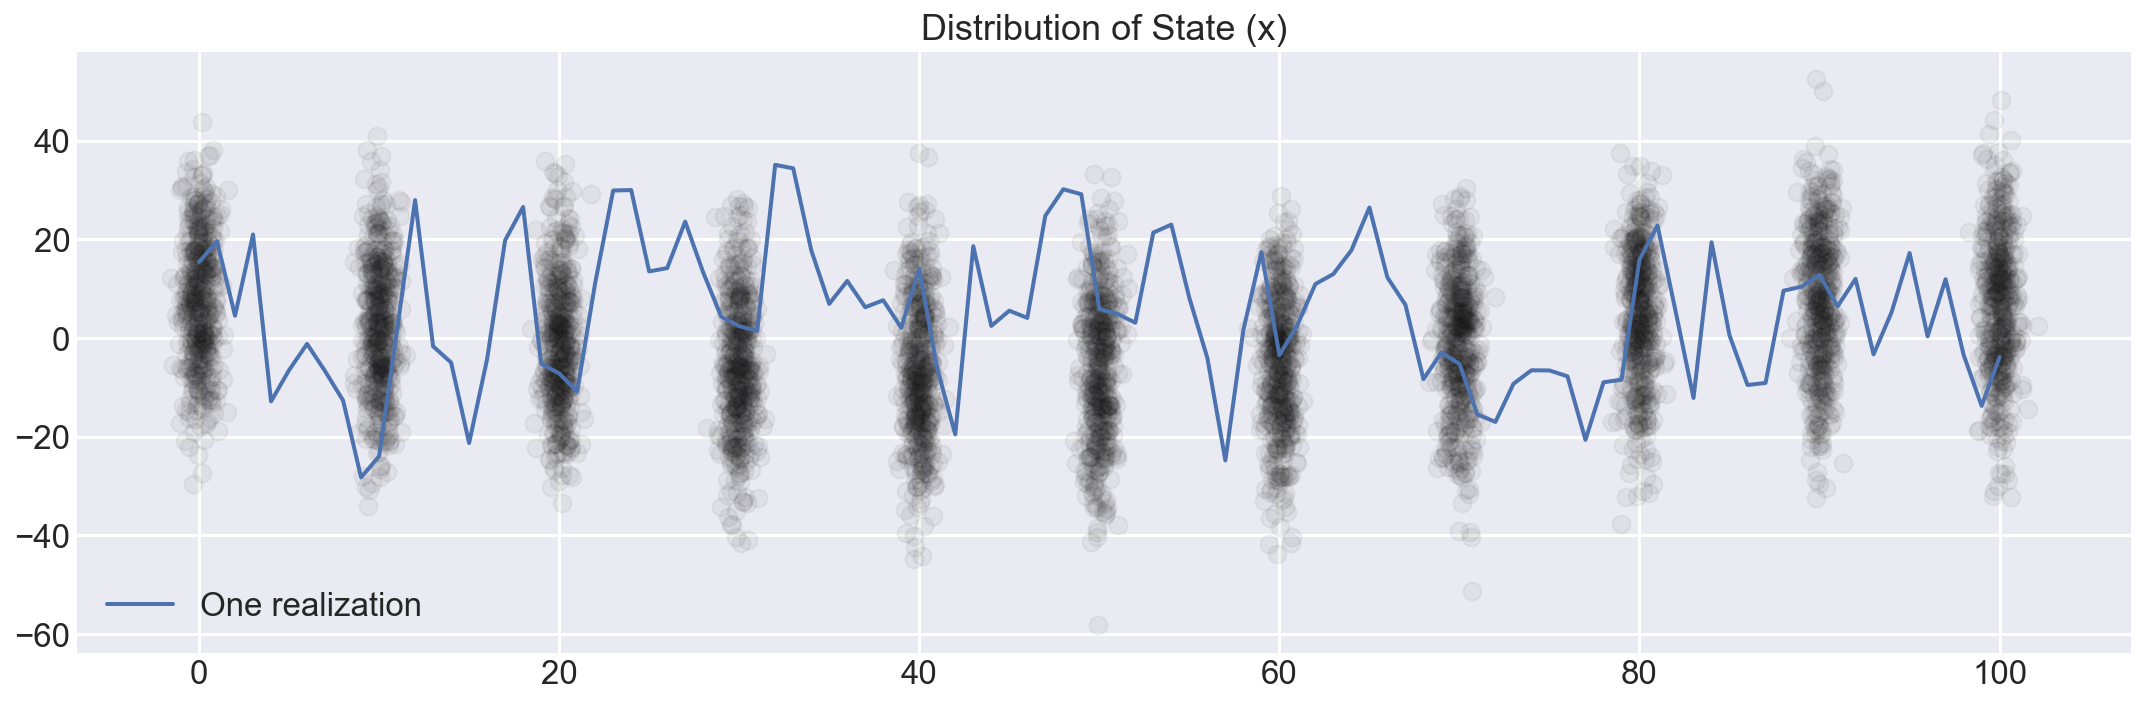

In [0]:
_, ax = plt.subplots(1, 1, figsize=(15, 5))
N = 500
x_current = tfd.Normal(0., sigma_1).sample(N)
y_current = y_current_step(x_current)
x_timestep = []
index = np.random.randint(N)
for i in range(101):
  x_timestep.append(x_current[index].numpy())
  x_current = x_next_step(x_current, i)
  y_current = y_current_step(x_current)
  if i % 10 == 0:
    ax.plot(i+np.random.randn(N)*.5,
            x_current,
            'o', color=dot_color, alpha=.05);

ax.plot(x_timestep, lw=2, label='One realization')
ax.set_title('Distribution of State (x)')
ax.legend();

In [0]:
SCALE = 10.
# For sampling $\tilde{x_t} \sim P(x_t|x_{t-1})$
GaussianKernel = lambda x: x + tf.random.normal(
    ps.shape(x), stddev=SCALE)

def gen_log_prob_fn(states):
  return tfd.Normal(states**2 / 20., sigma_w).log_prob

def important_sample_and_select(previous_states, current_observed):
  state_tilde = GaussianKernel(previous_states)
  importance_weight = gen_log_prob_fn(state_tilde)(current_observed)
  resample_index = tf.random.categorical(importance_weight[tf.newaxis, ...],
                                         tf.reduce_prod(*ps.shape(previous_states)))
  return tf.reshape(tf.gather(state_tilde, resample_index),
                    ps.shape(previous_states))

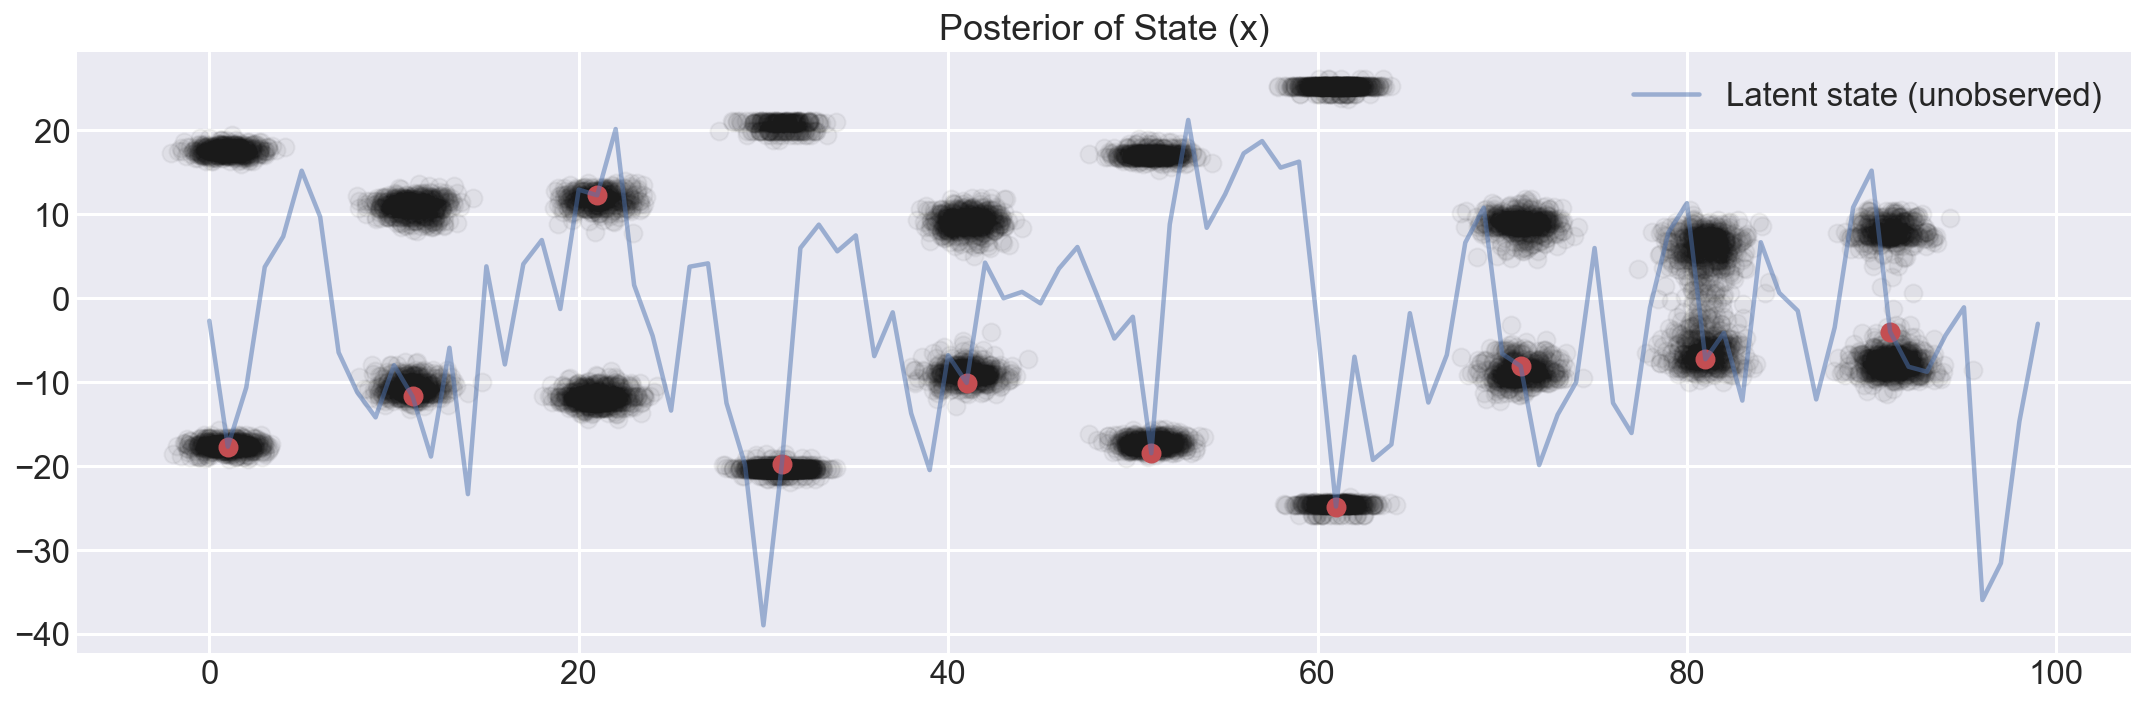

In [0]:
_, ax = plt.subplots(1, 1, figsize=(15, 5))

x_current = tfd.Normal(0., sigma_1).sample()
y_current = y_current_step(x_current)

n_particle = 1000
# Initialize particles by sampling from the prior
x_state = tfd.Normal(0., sigma_1).sample(n_particle)
x_timestep = []
x_state_time = []

for i in range(1, 101):
  x_timestep.append(x_current.numpy())
  x_current = x_next_step(x_current, i)
  y_current = y_current_step(x_current)
  x_state = important_sample_and_select(x_state, y_current)
  if i % 10 == 1:
    x_state_time.append((i, x_state.numpy()))
    ax.plot(i+np.random.randn(n_particle),
            x_state,
            'o', color=dot_color, alpha=.05);
    ax.plot(i, x_current, 'o', color='r');

ax.plot(x_timestep, alpha=.5, label='Latent state (unobserved)')
ax.set_title('Posterior of State (x)')
ax.legend();

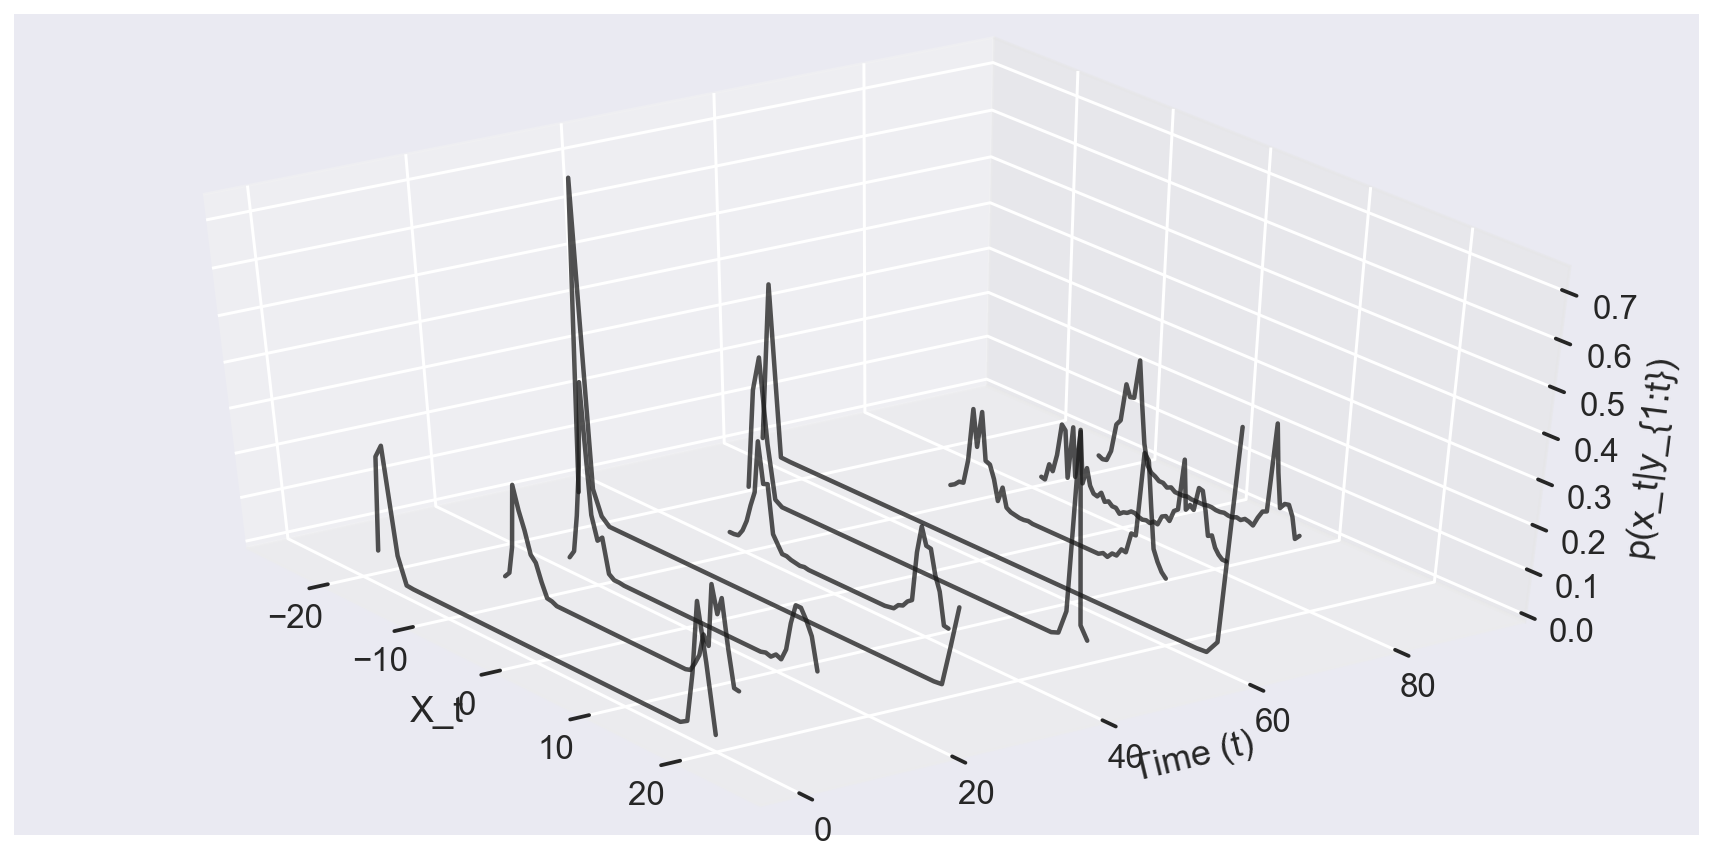

In [0]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 6))
ax = fig.gca(projection='3d')

for t, samples in x_state_time:
  hist, edge = np.histogram(samples, 50, density=True)
  ax.plot((edge[:-1] + edge[1:])/2, hist, zs=t, zdir='y', color='k', alpha=.75)

ax.set_xlabel('X_t')
ax.set_ylabel('Time (t)')
ax.set_zlabel('p(x_t|y_{1:t})')

ax.view_init(elev=40., azim=-35)

plt.show()

# SMC driver

SMC works by moving through successive stages. At each stage the inverse temperature $\beta$ is increased a little bit (starting from 0 up to 1).  
When $\beta = 0$ we have the prior distribution and when $\beta = 1$ we have the posterior distribution.  

So in more general terms we are always computing samples from a tempered posterior that we can write as:  
$$
        p(\theta \mid y)_{\beta} \propto p(y \mid \theta)^{\beta} p(\theta)
$$

[A summary of the algorithm](https://github.com/pymc-devs/pymc3/blob/master/pymc3/smc/sample_smc.py) is:
- Initialization:
  1. Initialize $\beta$ at zero and stage at zero.
  2. Generate N samples $S_{\beta}$ from the prior (because when $\beta = 0$ the tempered posterior is the prior).
- Sampling: Repeat from until $\beta \ge 1$(implemented as a `tf.while_loop`)
  3. Increase $\beta$ in order to make the effective sample size equals some predefined value (we use $N_t$, where $t$ is 0.5 by default).
  4. Compute a set of N importance weights W. The weights are computed as the ratio of the likelihoods of a sample at stage `i+1` and stage `i`.
  5. Obtain $S_{w}$ by re-sampling according to W.
  6. Use W to compute the covariance for the proposal distribution.
  7. For stages other than 0 use the acceptance rate from the previous stage to estimate the scaling of the proposal distribution and `n_steps`.
  8. Run N Metropolis chains (each one of length `n_steps`), starting each one from a different sample in $S_{w}$.
- Collect result
  9. The final result is a collection of N samples from the posterior.

In [0]:
from tensorflow_probability.python.experimental.mcmc.sample_sequential_monte_carlo import make_rwmh_kernel_fn

In [0]:
sample_sequential_monte_carlo_chain = tfp.experimental.mcmc.sample_sequential_monte_carlo

In [0]:
tfp.experimental.mcmc.sample_sequential_monte_carlo.__globals__['PRINT_DEBUG'] = True

As demonstration, we are setting up a MvNormal Mixture likelihood.

In [0]:
n = 4
mu = np.ones(n) * (1. / 2)
w = 0.1

prior_dist = tfd.Sample(tfd.Normal(0., 10.), sample_shape=n)
likelihood_dist = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(
        probs=[w, 1.-w]),
    components_distribution=tfd.MultivariateNormalDiag(
        loc=np.asarray([mu, -mu]).astype(np.float32),
        scale_identity_multiplier=[.1, .2]))

In [0]:
@tf.function()
def run_smc():
  n_stage, final_state, final_kernel_results = sample_sequential_monte_carlo_chain(
    prior_dist.log_prob,
    likelihood_dist.log_prob,
    prior_dist.sample(2000),
    make_kernel_fn=make_rwmh_kernel_fn,
    max_num_steps=50,
    )
  return n_stage, final_state, final_kernel_results

n_stage, final_state, final_kernel_results = run_smc()

Stage: 0 Beta: 0.000464439392 n_steps: 50 accept: 1 scaling: 1
Stage: 1 Beta: 0.00146937859 n_steps: 50 accept: 0.371102393 scaling: 1
Stage: 2 Beta: 0.00368027715 n_steps: 9 accept: 0.346806884 scaling: 1.15443385
Stage: 3 Beta: 0.00840179808 n_steps: 10 accept: 0.296738684 scaling: 1.30826092
Stage: 4 Beta: 0.0187417846 n_steps: 12 accept: 0.273453206 scaling: 1.40540349
Stage: 5 Beta: 0.0423224308 n_steps: 14 accept: 0.259473383 scaling: 1.46282387
Stage: 6 Beta: 0.0954942107 n_steps: 15 accept: 0.248899147 scaling: 1.49118054
Stage: 7 Beta: 0.211503565 n_steps: 16 accept: 0.235101447 scaling: 1.50883639
Stage: 8 Beta: 0.447728276 n_steps: 17 accept: 0.193502724 scaling: 1.4966656
Stage: 9 Beta: 0.982079625 n_steps: 21 accept: 0.159695029 scaling: 1.43458712
Stage: 10 Beta: 1 n_steps: 27 accept: 0.150257349 scaling: 1.32801485


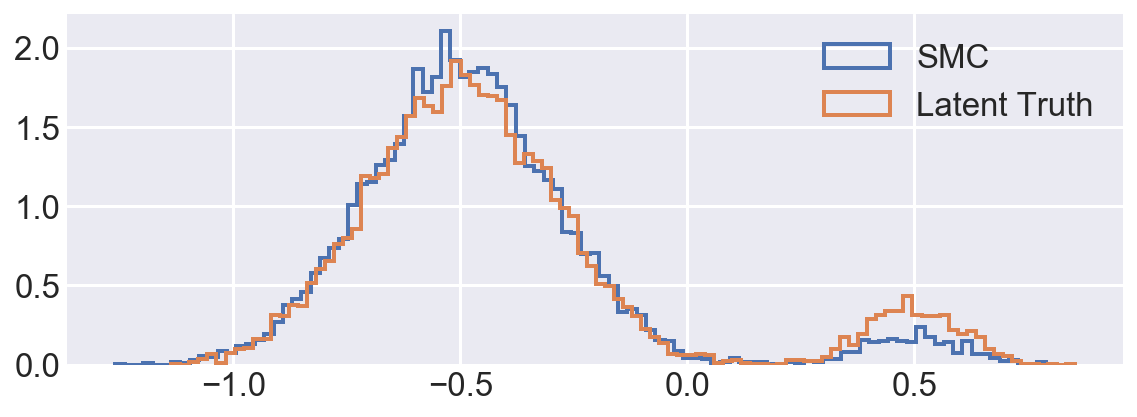

In [0]:
plt.figure(figsize=(8, 3))
plt.hist(np.ravel(final_state),
         bins=100, density=True, histtype='step', lw=2, label='SMC')
plt.hist(np.ravel(likelihood_dist.sample(2000)),
         bins=100, density=True, histtype='step', lw=2, label='Latent Truth')
plt.legend();

To do Approximate Bayesian Computation, you can implemented a Pseudo Likelihood function and pass it as arg `likelihood_log_prob_fn`. For example, you can write a function that takes the particles as input, simulate pseudo observation, and compute the distance between the simulated observation and the true observation.

# Examples

## Robust regression with mixture likelihood


In [0]:
#@title Set up data (Hogg 2010)
# cut & pasted directly from the fetch_hogg2010test() function
# identical to the original dataset as hardcoded in the Hogg 2010 paper

dfhogg = pd.DataFrame(
                np.array([[1, 201, 592, 61, 9, -0.84],
                          [2, 244, 401, 25, 4, 0.31],
                          [3, 47, 583, 38, 11, 0.64],
                          [4, 287, 402, 15, 7, -0.27],
                          [5, 203, 495, 21, 5, -0.33],
                          [6, 58, 173, 15, 9, 0.67],
                          [7, 210, 479, 27, 4, -0.02],
                          [8, 202, 504, 14, 4, -0.05],
                          [9, 198, 510, 30, 11, -0.84],
                          [10, 158, 416, 16, 7, -0.69],
                          [11, 165, 393, 14, 5, 0.30],
                          [12, 201, 442, 25, 5, -0.46],
                          [13, 157, 317, 52, 5, -0.03],
                          [14, 131, 311, 16, 6, 0.50],
                          [15, 166, 400, 34, 6, 0.73],
                          [16, 160, 337, 31, 5, -0.52],
                          [17, 186, 423, 42, 9, 0.90],
                          [18, 125, 334, 26, 8, 0.40],
                          [19, 218, 533, 16, 6, -0.78],
                          [20, 146, 344, 22, 5, -0.56]]),
                columns=['id','x','y','sigma_y','sigma_x','rho_xy'])

dfhogg['id'] = dfhogg['id'].apply(lambda x: 'p{}'.format(int(x)))
dfhogg.set_index('id', inplace=True)
dfhogg.head()

x      y  sigma_y  sigma_x  rho_xy
id                                        
p1  201.0  592.0     61.0      9.0   -0.84
p2  244.0  401.0     25.0      4.0    0.31
p3   47.0  583.0     38.0     11.0    0.64
p4  287.0  402.0     15.0      7.0   -0.27
p5  203.0  495.0     21.0      5.0   -0.33

In [0]:
dfhoggs = ((dfhogg[['x', 'y']] - dfhogg[['x', 'y']].mean(0)) / 
           (2 * dfhogg[['x', 'y']].std(0)))
dfhoggs['sigma_x'] = dfhogg['sigma_x'] / ( 2 * dfhogg['x'].std())
dfhoggs['sigma_y'] = dfhogg['sigma_y'] / ( 2 * dfhogg['y'].std())

In [0]:
dtype = tf.float64

hyper_mean = tf.cast(0, dtype)
hyper_scale = tf.cast(10, dtype)
X = dfhoggs['x'].values
sigma = dfhoggs['sigma_y'].values
Y = dfhoggs['y'].values

mdl_mixture = tfd.JointDistributionSequential([
  tfd.Normal(loc=hyper_mean, scale=hyper_scale),
  tfd.Normal(loc=hyper_mean, scale=hyper_scale),
  tfd.Normal(loc=hyper_mean, scale=10.),
  tfd.HalfNormal(scale=tf.cast(1., dtype)),
  tfd.Uniform(low=tf.cast(0, dtype), high=.5),
  lambda weight, sigma_out, mu_out, b1, b0: tfd.Independent(
      tfd.Mixture(
          tfd.Categorical(probs=tf.stack([
            tf.repeat(1-weight[..., tf.newaxis], 20, axis=-1),
            tf.repeat(weight[..., tf.newaxis], 20, axis=-1)
            ], -1)),
          [
           tfd.Normal(loc=tf.squeeze(b0[..., tf.newaxis] + b1[..., tf.newaxis]*X),
                      scale=np.squeeze(sigma)),
           tfd.Normal(loc=mu_out[..., tf.newaxis], 
                      scale=tf.squeeze(sigma+sigma_out[..., tf.newaxis]))
          ]
    ), 1)
], validate_args=True)

mdl_mixture.log_prob(mdl_mixture.sample())
mdl_mixture.log_prob(mdl_mixture.sample(7))
mdl_mixture.resolve_graph()

(('b0', ()),
 ('b1', ()),
 ('mu_out', ()),
 ('sigma_out', ()),
 ('weight', ()),
 ('x', ('weight', 'sigma_out', 'mu_out', 'b1', 'b0')))

In [0]:
# User provided, use samples from priors
prior_jd = tfd.JointDistributionSequential([
  tfd.Normal(loc=hyper_mean, scale=hyper_scale),
  tfd.Normal(loc=hyper_mean, scale=hyper_scale),
  tfd.Normal(loc=hyper_mean, scale=10.),
  tfd.HalfNormal(scale=tf.cast(1., dtype)),           
  tfd.Uniform(low=tf.cast(0, dtype), high=.5),
], validate_args=True)

In [0]:
draws = 5000
init_population_ = prior_jd.sample(draws)

In [0]:
# bijector to map contrained parameters to real
a, b = tf.constant(0., dtype), tf.constant(.5, dtype),

# Interval transformation
tfp_interval = tfb.Inline(
    inverse_fn=(
        lambda x: tf.math.log(x - a) - tf.math.log(b - x)),
    forward_fn=(
        lambda y: (b - a) * tf.sigmoid(y) + a),
    forward_log_det_jacobian_fn=(
        lambda x: tf.math.log(b - a) - 2. * tf.nn.softplus(-x) - x),
    forward_min_event_ndims=0,
    name="interval")

unconstraining_bijectors = [
    tfb.Identity(),
    tfb.Identity(),
    tfb.Identity(),
    tfb.Exp(),
    tfp_interval,
]

In [0]:
_inverse_transform = make_transform_fn(unconstraining_bijectors, 'inverse')
_forward_transform = make_transform_fn(unconstraining_bijectors, 'forward')

# Generate model prior_log_prob_fn and likelihood_log_prob_fn. User provided.
prior_log_prob_fn_ = lambda *x: prior_jd.log_prob(x)
prior_log_prob_fn = make_transformed_log_prob(
    prior_log_prob_fn_,
    unconstraining_bijectors,
    direction='forward',
    # TODO(b/72831017): Disable caching until gradient linkage
    # generally works.
    enable_bijector_caching=False)

def likelihood_log_prob_fn_(b0, b1, mu_out, sigma_out, weight):
  return tfd.Independent(
    tfd.Mixture(
        tfd.Categorical(probs=tf.stack([
          tf.repeat(1-weight[..., tf.newaxis], 20, axis=-1),
          tf.repeat(weight[..., tf.newaxis], 20, axis=-1)
          ], -1)),
        [
         tfd.Normal(loc=b0[..., tf.newaxis] + b1[..., tf.newaxis]*X,
                    scale=sigma),
         tfd.Normal(loc=mu_out[..., tf.newaxis],
                    scale=sigma+sigma_out[..., tf.newaxis])
        ]
  ), 1).log_prob(Y)

def likelihood_log_prob_fn(*state_parts):
  return likelihood_log_prob_fn_(*_forward_transform(state_parts))

In [0]:
# Evaluate the prior_log_prob_fn and likelihood_log_prob_fn on initial population
prior_log_prob_val_ = prior_log_prob_fn_(*init_population_)

init_population = _inverse_transform(init_population_)

prior_log_prob_val = prior_log_prob_fn(*init_population)
likelihood_log_prob_val = likelihood_log_prob_fn(*init_population)

if True:  # Set True to debug
  np.testing.assert_allclose(
      prior_log_prob_val_ + likelihood_log_prob_val,
      mdl_mixture.log_prob(*init_population_, Y))

  model_logp = make_transformed_log_prob(
      lambda *x: mdl_mixture.log_prob(*x, Y),
      unconstraining_bijectors,
      direction='forward',
      # TODO(b/72831017): Disable caching until gradient linkage
      # generally works.
      enable_bijector_caching=False)

  np.testing.assert_allclose(
      prior_log_prob_val + likelihood_log_prob_val,
      model_logp(*init_population))

In [0]:
tfp.experimental.mcmc.sample_sequential_monte_carlo.__globals__['PRINT_DEBUG'] = False

@tf.function(experimental_compile=True)
def run_smc():
  n_stage, final_state, final_kernel_results = sample_sequential_monte_carlo_chain(
    prior_log_prob_fn,
    likelihood_log_prob_fn,
    init_population,
    make_kernel_fn=make_rwmh_kernel_fn,
    max_num_steps=50
    )
  return n_stage, final_state, final_kernel_results

In [0]:
%%time

n_stage, final_state, final_kernel_results = run_smc()

CPU times: user 3.34 s, sys: 450 ms, total: 3.79 s
Wall time: 4.84 s


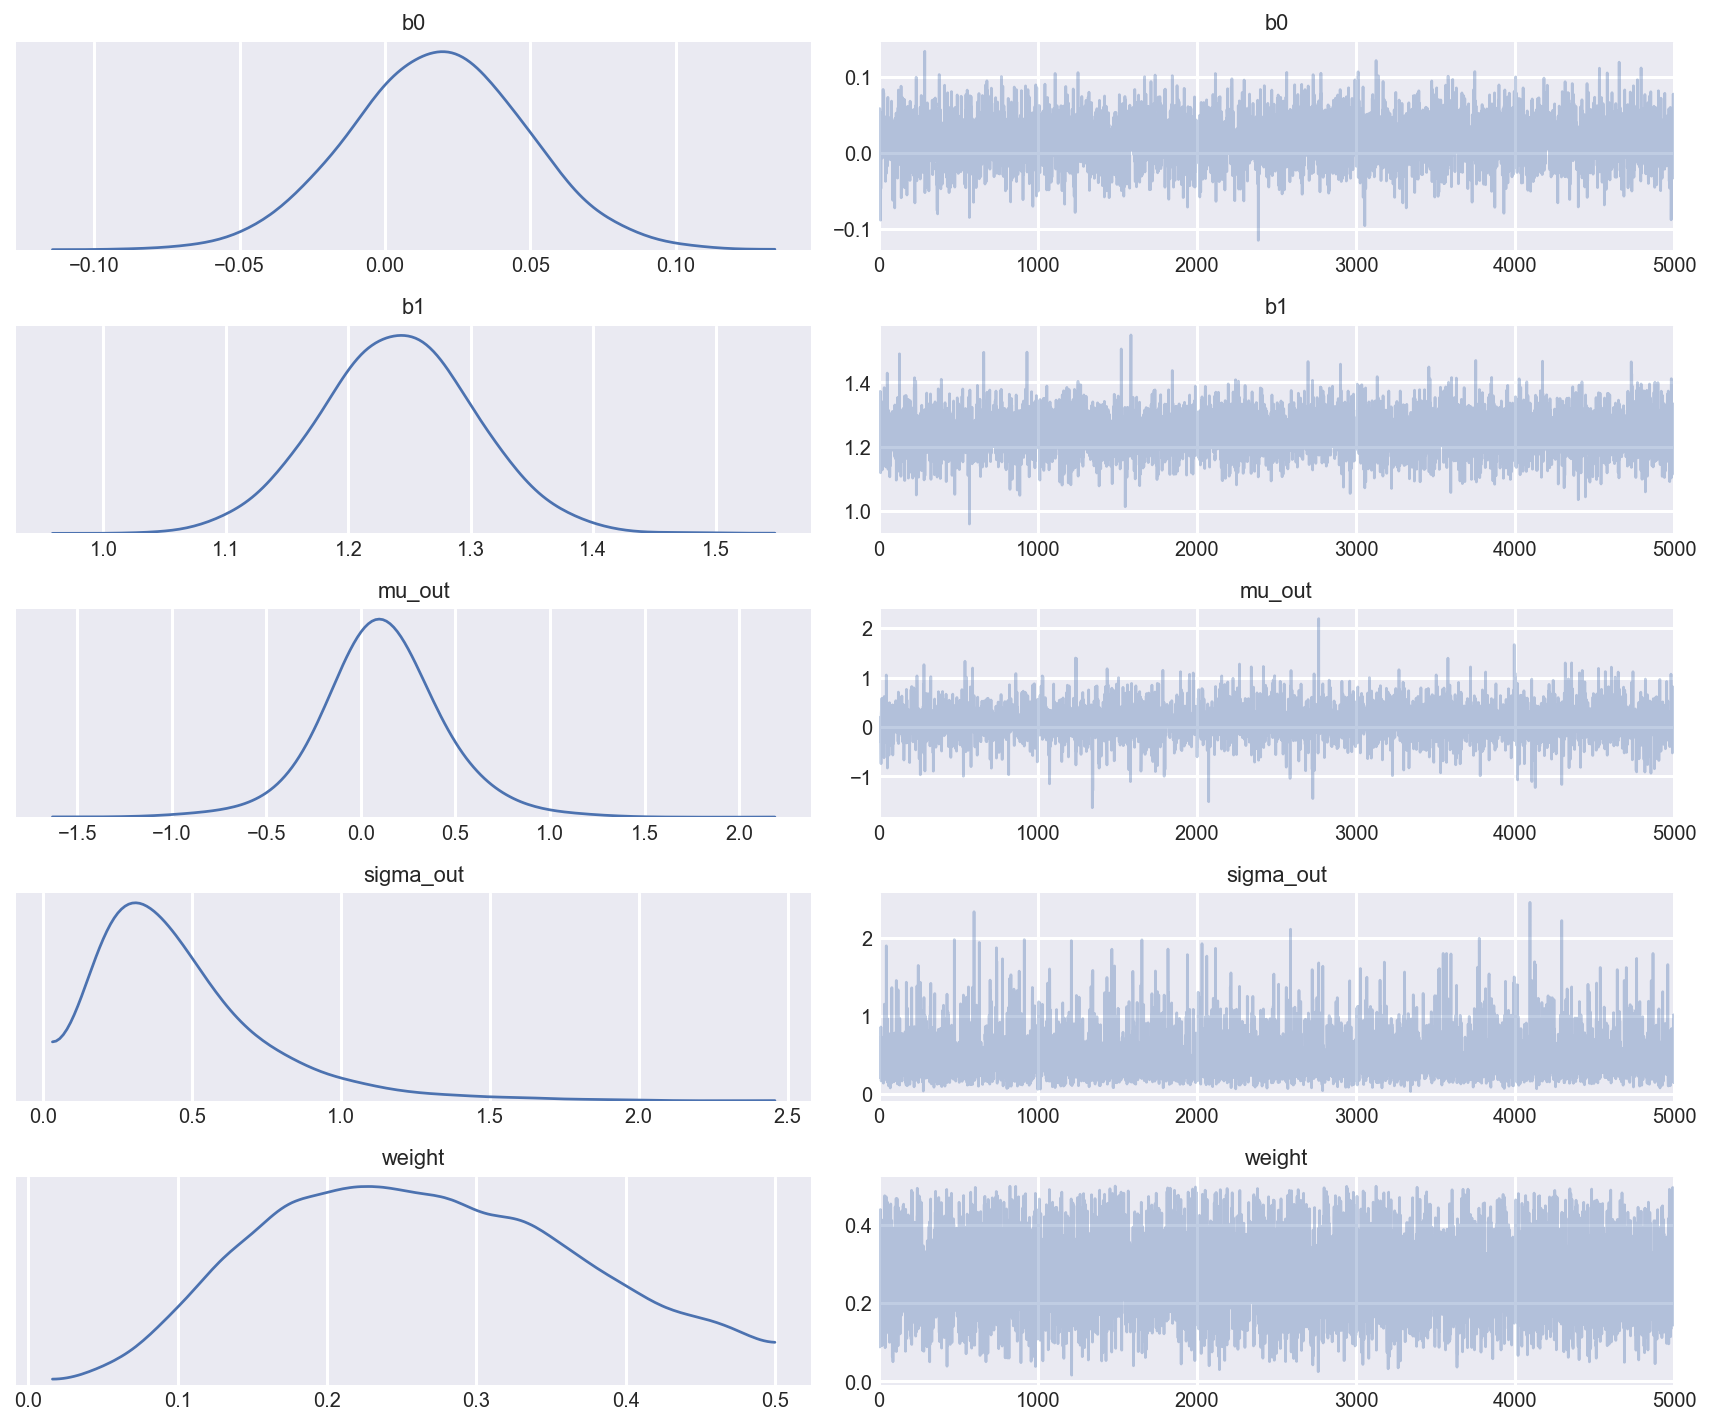

In [0]:
var_name = ['b0', 'b1', 'mu_out', 'sigma_out', 'weight']
posterior = {k:bij.forward(v).numpy()[np.newaxis, ...]
             for k, v, bij in zip(var_name, final_state, unconstraining_bijectors)}

az_trace = az.from_dict(posterior=posterior)
az.plot_trace(az_trace);

### Comparison with NUTS
Using SMC result as initialization.

In [0]:
nchain = 10
b0, b1, mu_out, sigma_out, weight, _ = mdl_mixture.sample(nchain)
init_state = [tf.ones_like(b0) * .1, tf.ones_like(b1),
              tf.ones_like(mu_out), tf.ones_like(sigma_out),
              tf.ones_like(weight) * .1]

target_log_prob_fn = lambda *init_state: mdl_mixture.log_prob(
    *init_state, dfhoggs['y'].values)

step_size = [tf.math.reduce_std(x) for x in final_state]

# target_log_prob_fn(*init_state)

In [0]:
# @title A common `run_chain` function
@tf.function(autograph=False, experimental_compile=True)
def run_chain(init_state, step_size, target_log_prob_fn, unconstraining_bijectors,
              num_steps=500, burnin=50):

    def trace_fn(_, pkr):
        return (
            pkr.inner_results.inner_results.target_log_prob,
            pkr.inner_results.inner_results.leapfrogs_taken,
            pkr.inner_results.inner_results.has_divergence,
            pkr.inner_results.inner_results.energy,
            pkr.inner_results.inner_results.log_accept_ratio
        )

    kernel = tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=tfp.mcmc.NoUTurnSampler(
            target_log_prob_fn,
            step_size=step_size),
        bijector=unconstraining_bijectors)

    hmc = tfp.mcmc.DualAveragingStepSizeAdaptation(
        inner_kernel=kernel,
        num_adaptation_steps=burnin,
        target_accept_prob=0.8
        )

    # Sampling from the chain.
    chain_state, sampler_stat = tfp.mcmc.sample_chain(
        num_results=num_steps,
        num_burnin_steps=burnin,
        current_state=init_state,
        kernel=hmc,
        trace_fn=trace_fn)
    return chain_state, sampler_stat

In [0]:
%%time

samples, sampler_stat = run_chain(
    init_state, step_size, 
    target_log_prob_fn, unconstraining_bijectors, burnin=500)

CPU times: user 10.5 s, sys: 2.05 s, total: 12.5 s
Wall time: 13.7 s


In [0]:
# Compare to a bad initialization with `step_size=1.`
%%time

_ = run_chain(
    init_state, tf.cast(1., dtype=dtype), 
    target_log_prob_fn, unconstraining_bijectors, burnin=500)

CPU times: user 39.6 s, sys: 11.6 s, total: 51.2 s
Wall time: 52 s


In [0]:
# using the pymc3 naming convention
sample_stats_name = ['lp', 'tree_size', 'diverging', 'energy', 'mean_tree_accept']
sample_stats = {k:v.numpy().T for k, v in zip(sample_stats_name, sampler_stat)}

var_name = ['b0', 'b1', 'mu_out', 'sigma_out', 'weight']
posterior = {k:np.swapaxes(v.numpy(), 1, 0)
             for k, v in zip(var_name, samples)}

az_trace = az.from_dict(posterior=posterior, sample_stats=sample_stats)

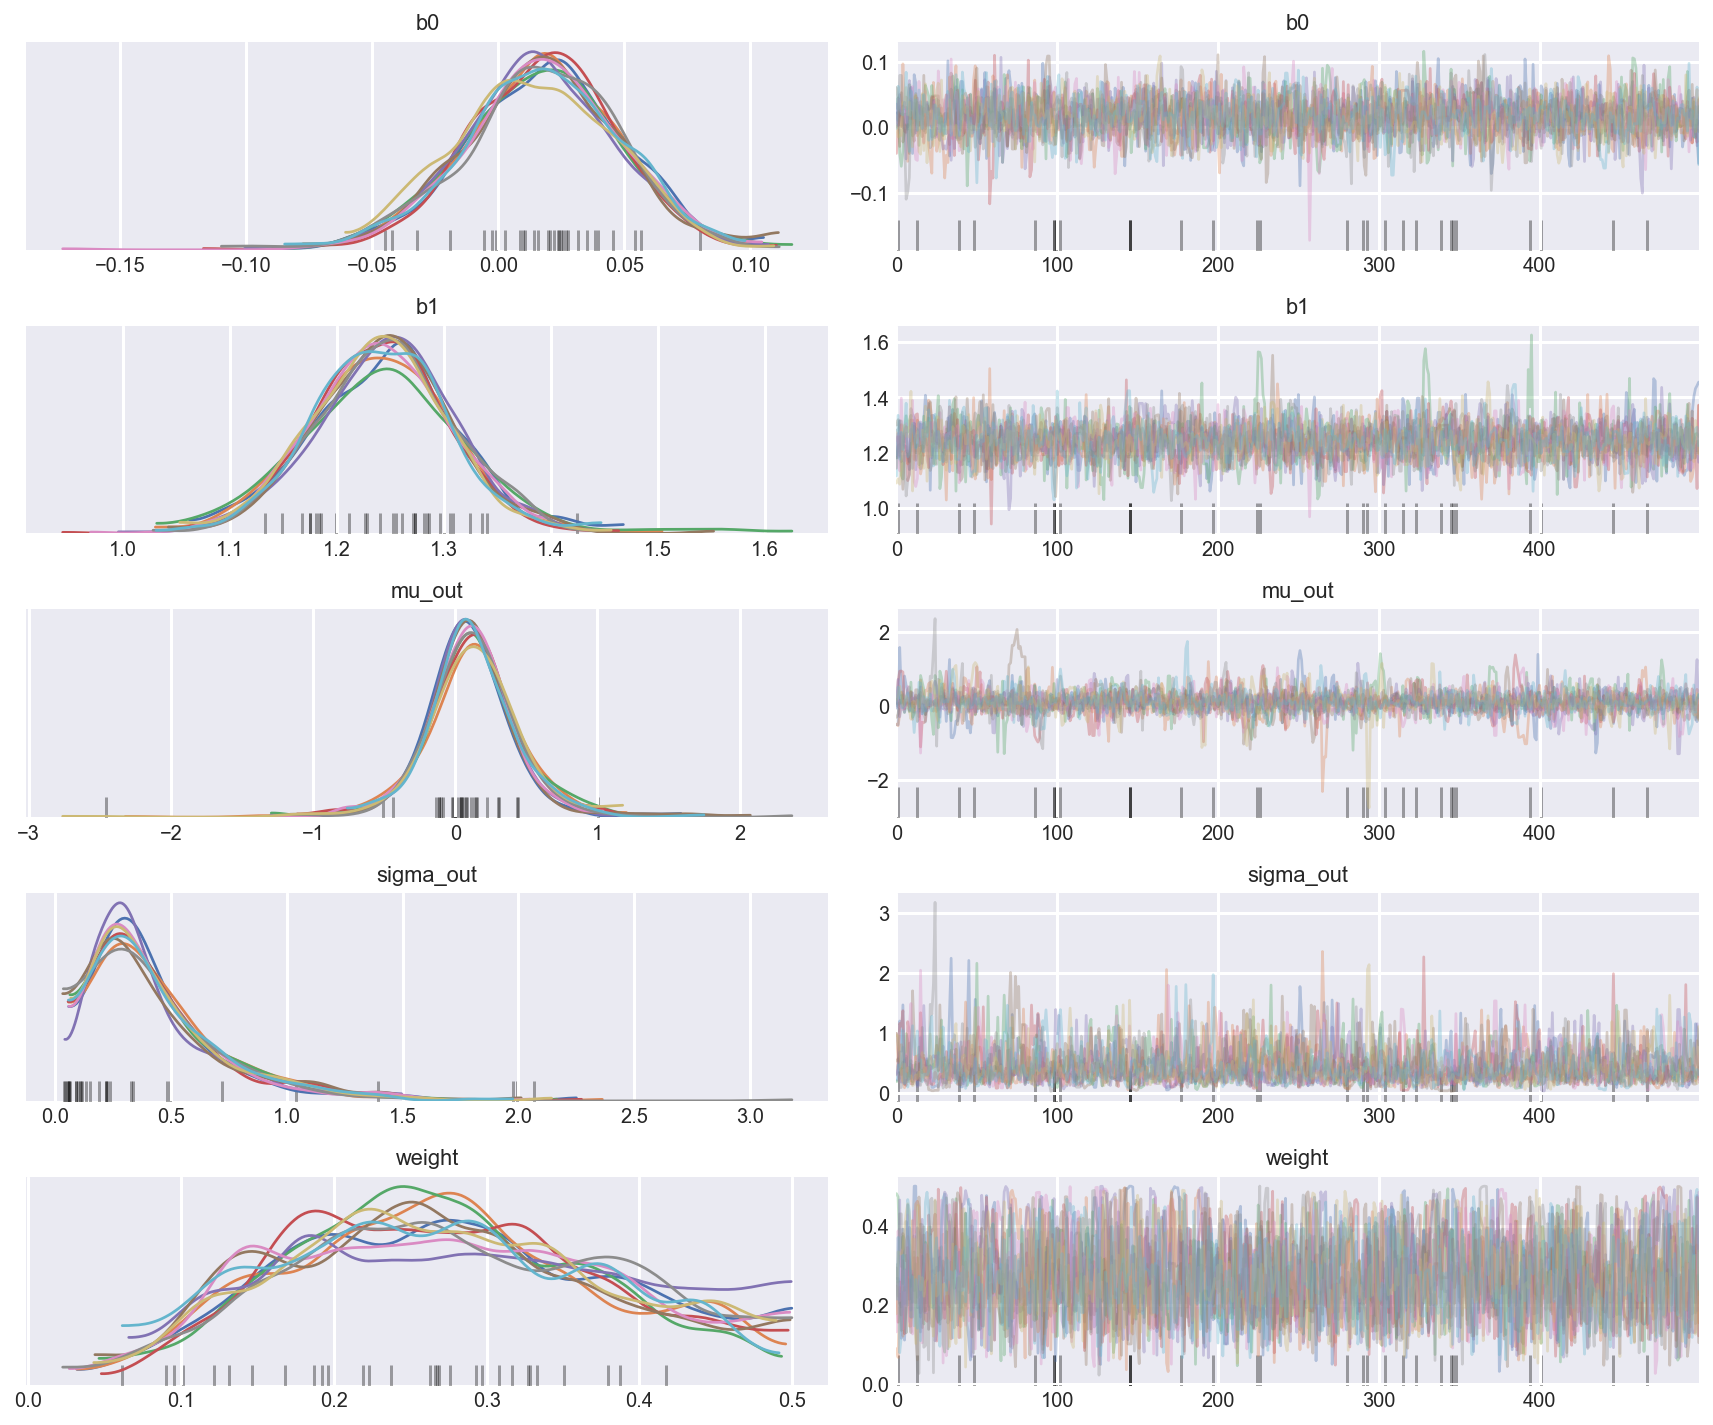

In [0]:
az.plot_trace(az_trace);

In [0]:
az.summary(az_trace)

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  ess_bulk  ess_tail  r_hat
b0         0.016  0.031  -0.044    0.071      0.000    0.000    4572.0  3211.0    4617.0    3682.0    1.0
b1         1.241  0.067   1.112    1.364      0.001    0.001    3861.0  3793.0    4026.0    3035.0    1.0
mu_out     0.108  0.325  -0.485    0.749      0.007    0.006    2244.0  1550.0    2823.0    2030.0    1.0
sigma_out  0.440  0.301   0.041    0.998      0.006    0.004    2653.0  2653.0    2398.0    1774.0    1.0
weight     0.273  0.106   0.101    0.479      0.002    0.001    3676.0  2987.0    3556.0    2195.0    1.0

In [0]:
np.sum(az_trace.sample_stats['diverging'], axis=1)

<xarray.DataArray 'diverging' (chain: 10)>
array([3, 2, 0, 4, 3, 6, 3, 3, 1, 5])
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9

### Also works with `TransformedTransitionKernel` and HMC as inner kernel

In [0]:
from tensorflow_probability.python.experimental.mcmc.sample_sequential_monte_carlo import gen_make_transform_hmc_kernel_fn
from tensorflow_probability.python.experimental.mcmc.sample_sequential_monte_carlo import simple_heuristic_tuning

import functools

simple_heuristic_tuning_hmc = functools.partial(
    simple_heuristic_tuning, optimal_accept=.6)

In [0]:
_make_transform_hmc_kernel_fn = gen_make_transform_hmc_kernel_fn(
    unconstraining_bijectors,
    num_leapfrog_steps=10)

@tf.function(experimental_compile=True)
def run_smc():
  n_stage, final_state, final_kernel_results = sample_sequential_monte_carlo_chain(
    prior_log_prob_fn_,
    likelihood_log_prob_fn_,
    prior_jd.sample([1000, 5]),
    make_kernel_fn=_make_transform_hmc_kernel_fn,
    tuning_fn=simple_heuristic_tuning_hmc,
    min_num_steps=10
    )
  return n_stage, final_state, final_kernel_results

n_stage, final_state, final_kernel_results = run_smc()

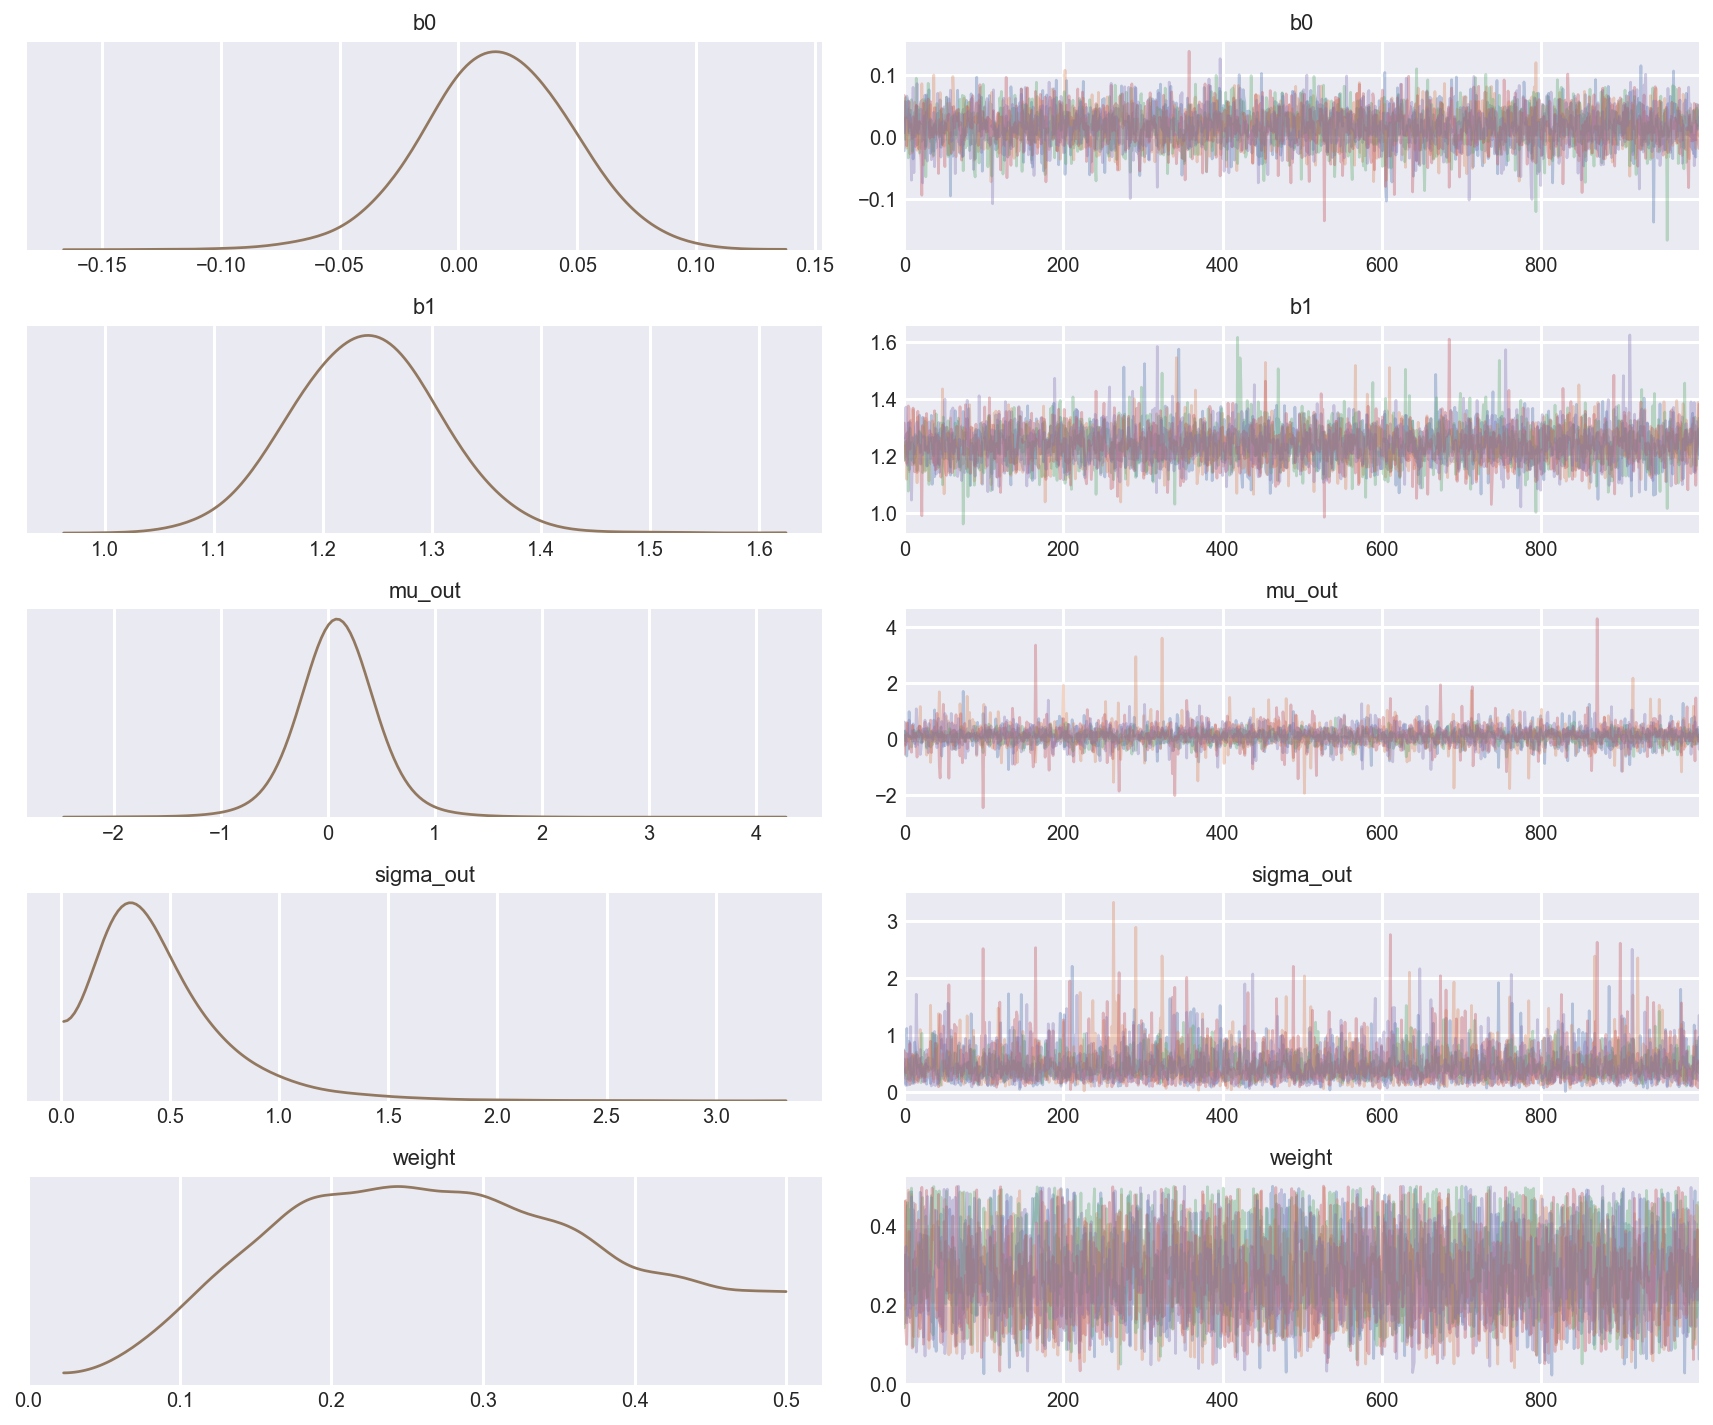

In [0]:
var_name = ['b0', 'b1', 'mu_out', 'sigma_out', 'weight']
posterior = {k: np.swapaxes(v.numpy(), 1, 0)
             for k, v in zip(var_name, final_state)}

az_trace = az.from_dict(posterior=posterior)
az.plot_trace(az_trace, combined=True);

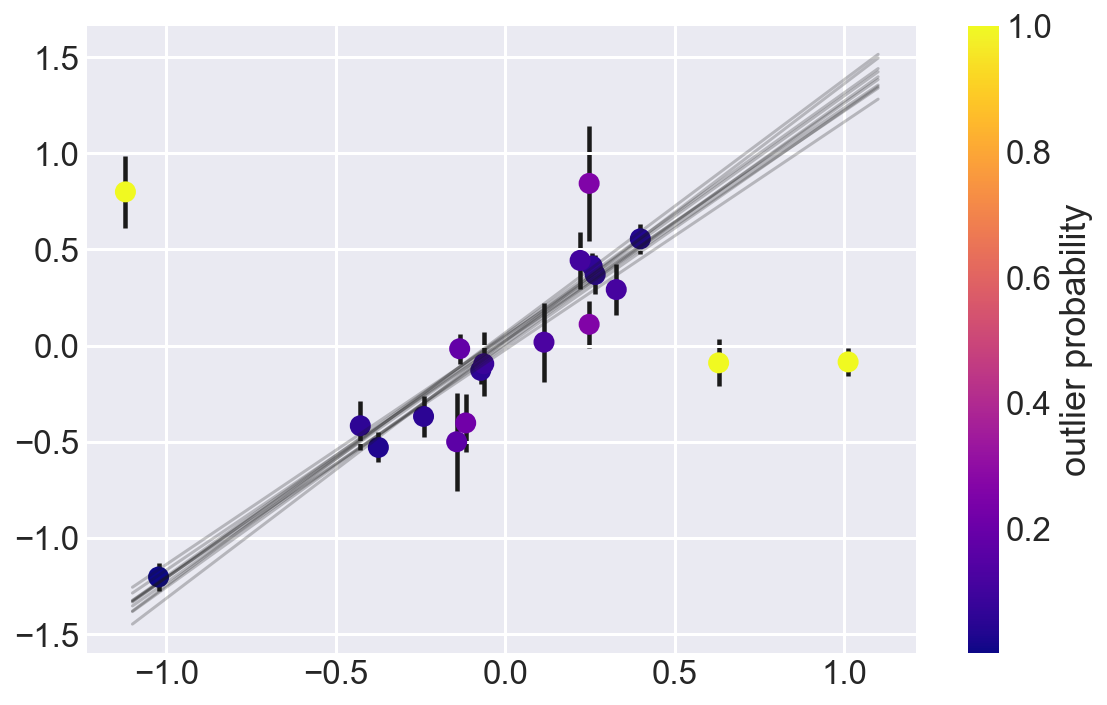

In [0]:
#@title Display fitted result and outliner probability
b0, b1, mu_out, sigma_out, weight = [
    tf.reshape(x, (500*10, 1)) for x in final_state]
X = dfhoggs['x'].values[tf.newaxis, ...]
sigma = dfhoggs['sigma_y'].values[tf.newaxis, ...]
y_obs = dfhoggs['y'].values[tf.newaxis, ...]

_, ax = plt.subplots(1, 1, figsize=(8, 5))
x_fit = np.linspace(-1.1, 1.1, 100)[None, :]
ax.plot(x_fit.T, np.transpose(b0[:10] + b1[:10]*x_fit), 
        alpha=.25, lw=1.5, color=dot_color)

outlier_logp = tf.math.log(weight) + tfd.Normal(
    loc=mu_out, scale=sigma+sigma_out).log_prob(y_obs)

marg_logp = tfd.Mixture(
    tfd.Categorical(probs=tf.stack(
        [tf.repeat(1-weight, 20, axis=1),
         tf.repeat(weight, 20, axis=1)], 2)),
    [
        tfd.Normal(loc=b0 + b1*X, scale=sigma),
        tfd.Normal(loc=mu_out, scale=sigma+sigma_out)
    ]
).log_prob(y_obs)

logp_outlier = outlier_logp - marg_logp

ax.errorbar(dfhoggs['x'],
            dfhoggs['y'], 
            yerr=dfhoggs['sigma_y'], 
            fmt=','+dot_color, 
            zorder=-1)

p_outlier = np.exp(np.median(logp_outlier, axis=0))

plt.scatter(dfhoggs['x'], dfhoggs['y'], c=p_outlier, cmap='plasma')
plt.colorbar(ax=ax, label="outlier probability");

## ODE (Lotka-Volterra equation)

In [0]:
# Definition of parameters
a = 1.
b = 0.1
c = 1.5
d = 0.75

# initial population of rabbits and foxes
X0 = [10., 5.]
# size of data
size = 100
# time lapse
time = 15
t = np.linspace(0, time, size)

In [0]:
Run_quick_profiling = True #@param {type:"boolean"}
if Run_quick_profiling:
  from scipy.integrate import odeint
  ode_dp = tfp.math.ode.DormandPrince()
  ode_bdf = tfp.math.ode.BDF()

  # Lotka - Volterra equation
  def ode_fn(t, X, a, b, c, d):
    """ Return the growth rate of fox and rabbit populations. """
    return tf.stack([a*X[0] - b*X[0]*X[1],
                  -c*X[1] + d*b*X[0]*X[1]])

  def run_scipy(init_cond, a, b, c, d):
    ode_fn_ = lambda X, t: ode_fn(t, X, a, b, c, d)
    return odeint(
        ode_fn_,
        y0=init_cond,
        t=t,
        rtol=0.1)

  @tf.function(experimental_compile=True)
  def run_dp(init_cond, a, b, c, d):
    ode_fn_ = lambda t, X: ode_fn(t, X, a, b, c, d)
    return ode_dp.solve(
        ode_fn_, 
        initial_time=0., 
        initial_state=init_cond, 
        solution_times=t).states

  @tf.function(experimental_compile=True)
  def run_bdf(init_cond, a, b, c, d):
    ode_fn_ = lambda t, X: ode_fn(t, X, a, b, c, d)
    return ode_bdf.solve(
        ode_fn_, 
        initial_time=0., 
        initial_state=init_cond, 
        solution_times=t).states

  # run once
  _ = run_dp(tf.cast(X0, tf.float32), a, b, c, d)
  _ = run_bdf(tf.cast(X0, tf.float32), a, b, c, d)
  _ = run_scipy(X0, a, b, c, d)

  print('Scaler version')
  print('DormandPrince')
  %timeit _ = run_dp(tf.cast(X0, tf.float32), a, b, c, d)
  print('BDF')
  %timeit _ = run_bdf(tf.cast(X0, tf.float32), a, b, c, d)
  print('Scipy')
  %timeit _ = run_scipy(X0, a, b, c, d)

  print('Batch version')
  print('DormandPrince')
  %timeit _ = run_dp(tf.cast(np.repeat([X0], 10, axis=0).T, tf.float32), *[tf.ones(10) * x for x in [a, b, c, d]])
  print('BDF')
  %timeit _ = run_bdf(tf.cast(np.repeat([X0], 10, axis=0).T, tf.float32), *[tf.ones(10) * x for x in [a, b, c, d]])
  print('Scipy')
  %timeit _ = np.asarray([run_scipy(X0, a_, b_, c_, d_) for a_, b_, c_, d_ in zip(*[tf.ones(10) * x for x in [a, b, c, d]])])

Scaler version
DormandPrince
100 loops, best of 3: 5.46 ms per loop
BDF
1 loops, best of 3: 201 ms per loop
Scipy
1000 loops, best of 3: 1.07 ms per loop
Batch version
DormandPrince
1 loops, best of 3: 6.71 ms per loop
BDF
1 loops, best of 3: 580 ms per loop
Scipy
1 loops, best of 3: 235 ms per loop


In [0]:
# ode_int = tfp.math.ode.BDF()
ode_int = tfp.math.ode.DormandPrince()

# simulator function
@tf.function(experimental_compile=True)
def competition_model(x0, y0, alpha, beta, gamma, delta):
  # Lotka - Volterra equation
  def ode_fn(t, X):
    """ Return the growth rate of fox and rabbit populations. """
    dX_dt = alpha*X[0] - beta*X[0]*X[1]
    dY_dt = -gamma*X[1] + delta*beta*X[0]*X[1]
    return [dX_dt, dY_dt]

  return ode_int.solve(
      ode_fn,
      initial_time=0.,
      initial_state=[x0, y0],
      solution_times=t)

# Generating noisy data to be used as observed data.
def add_noise(x0, y0, a, b, c, d):
  noise = np.random.normal(size=(size, 2))
  simulated = tf.stack(competition_model(
      x0, y0, a, b, c, d).states).numpy().T
  simulated += noise
  indexes = np.sort(np.random.randint(low=0, high=size, size=size))    
  return simulated[indexes]

observed = add_noise(X0[0], X0[1], a, b, c, d)

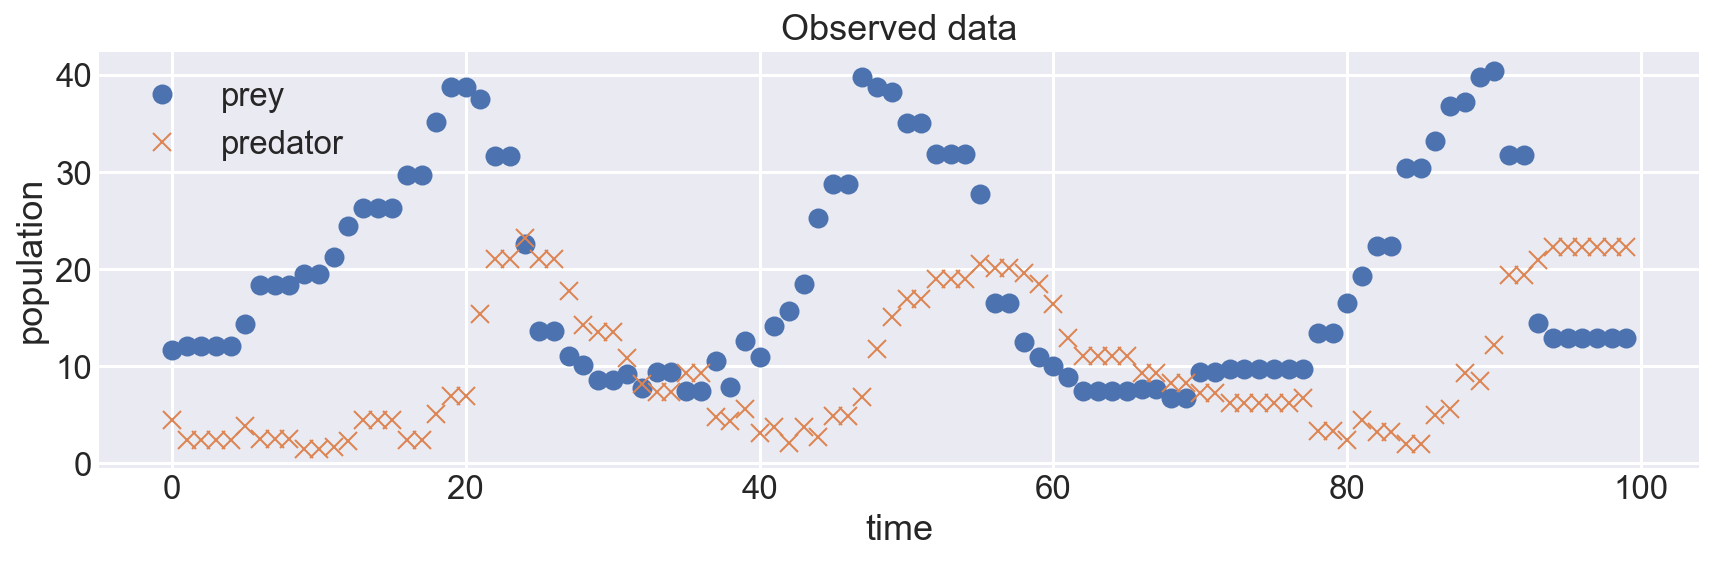

In [0]:
# plotting observed data.
def plot_ode(state0, state1):
  _, ax = plt.subplots(figsize=(12,4))
  ax.plot(state0, 'o', label='prey')
  ax.plot(state1, 'x', label='predator')
  ax.set_xlabel('time')
  ax.set_ylabel('population')
  ax.set_title('Observed data')
  return ax

ax = plot_ode(observed[:,0], observed[:,1])
ax.legend();

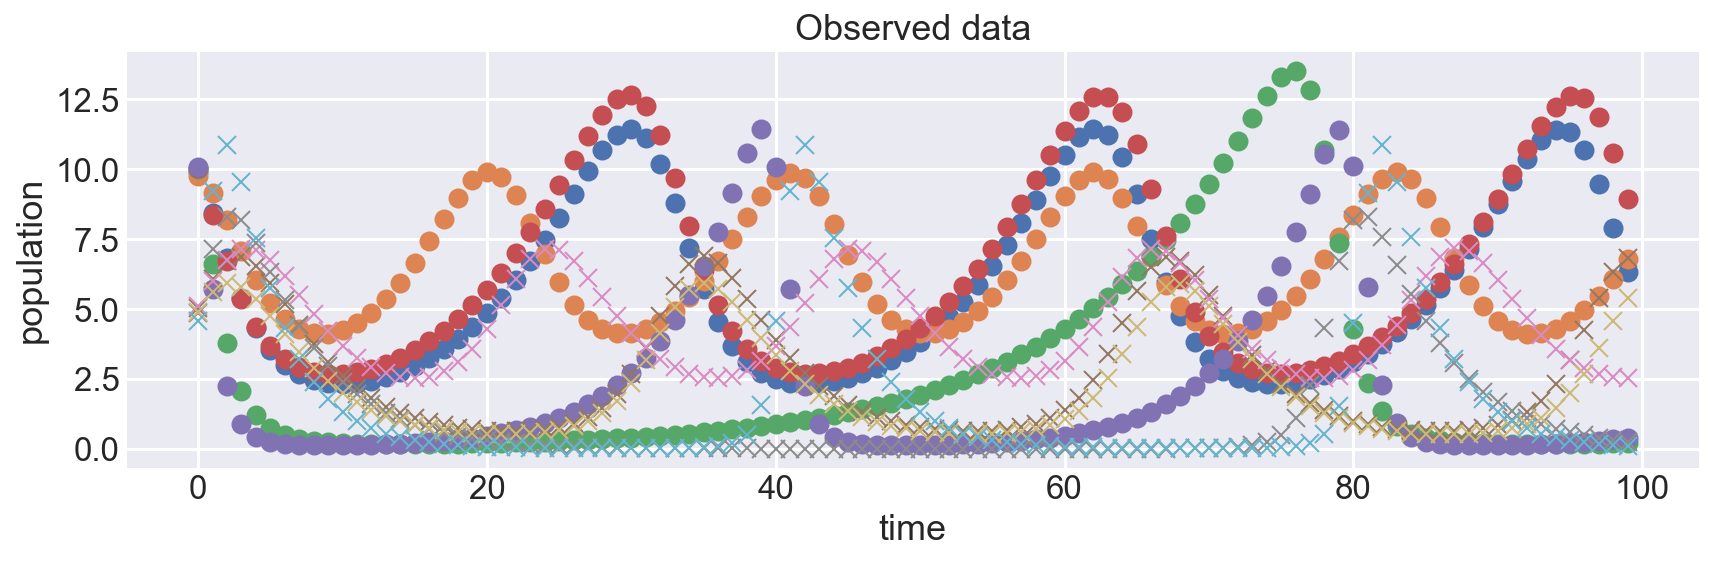

In [0]:
ode_prior = tfd.JointDistributionSequential([
  tfd.Normal(X0[0], .25),
  tfd.Normal(X0[1], .25),
  tfd.Normal(1., .5),
  tfd.Normal(.5, .1),
  tfd.Normal(2., .5),
  tfd.Normal(1., .1),
])

result = competition_model(*ode_prior.sample(5))
ax = plot_ode(result.states[0], result.states[1])

In [0]:
epsilon = .5
kernel = tfd.Normal(0., epsilon)

def absolute_error(observed, simulated):
  return tf.reduce_mean(
      tf.abs(observed-simulated), axis=[0, 1])

def pseudolikelihood(x0, y0, alpha, beta, gamma, delta):
  sim_data = competition_model(x0, y0, alpha, beta, gamma, delta)
  distance = absolute_error(
      observed.T[..., tf.newaxis], tf.stack(sim_data.states))
  return kernel.log_prob(distance)

FYI: ODE with correct gradient on parameter inputs:

In [0]:
variables = ode_prior.sample(5)
with tf.GradientTape() as tape:
  tape.watch(variables)
  log_p = pseudolikelihood(*variables)
grad = tape.gradient(log_p, variables)
print(grad)

[<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([ 4.2884326 , -1.7172928 , -1.0834885 , -0.73512506, -1.3000488 ],
      dtype=float32)>, <tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-1.4968691, -2.1689885, -2.8412762, -2.4071507, -2.4089975],
      dtype=float32)>, None, None, None, None]


In [0]:
@tf.function(experimental_compile=True)
def competition_model2(x0, y0, alpha, beta, gamma, delta):
  # Lotka - Volterra equation
  def ode_fn(t, X, alpha, beta, gamma, delta):
    """ Return the growth rate of fox and rabbit populations. """
    dX_dt = alpha*X[0] - beta*X[0]*X[1]
    dY_dt = -gamma*X[1] + delta*beta*X[0]*X[1]
    return [dX_dt, dY_dt]

  return ode_int.solve(
      ode_fn,
      initial_time=0.,
      initial_state=[x0, y0],
      solution_times=t,
      constants={'alpha': alpha, 
                 'beta': beta,
                 'gamma': gamma,
                 'delta': delta})

@tf.function(experimental_compile=True)
def pseudolikelihood2(x0, y0, alpha, beta, gamma, delta):
  sim_data = competition_model2(x0, y0, alpha, beta, gamma, delta)
  distance = absolute_error(
      observed.T[..., tf.newaxis], tf.stack(sim_data.states[:2]))
  return kernel.log_prob(distance)

with tf.GradientTape() as tape:
  tape.watch(variables)
  log_p = pseudolikelihood2(*variables)
grad = tape.gradient(log_p, variables)
print(grad)

[<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([ 4.2884707, -1.7180843, -1.0834928, -0.7351227, -1.3005683],
      dtype=float32)>, <tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-1.4968197, -2.1684072, -2.8412826, -2.4071457, -2.4091287],
      dtype=float32)>, <tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-105.23753  ,  -26.075418 ,   11.526417 ,   10.878567 ,
         -3.5587904], dtype=float32)>, <tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-233.3023  , -354.4104  , -395.9037  ,  -27.165846, -333.51367 ],
      dtype=float32)>, <tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-36.382977,  -2.820639,  28.64179 ,   7.233366,  19.52233 ],
      dtype=float32)>, <tf.Tensor: shape=(5,), dtype=float32, numpy=
array([ -40.79319 ,  -81.69515 , -119.26618 ,  -16.452305,  -99.12879 ],
      dtype=float32)>]


Currently, the Random Walk kernel is adapting to the scale of the posterior samples at each inverse temperature, which could give proposal that are difficult to simulated from (i.e., the TFP ode solver runs too slows with some inputs that produce large ode states).

In [0]:
def _make_rescale_rwmh_kernel_fn(target_log_prob_fn, init_state, scalings):
  state_std = [tf.math.reduce_std(x, axis=0, keepdims=True) for x in init_state]
  step_size = [s * tf.cast(
      ps.reshape(scalings * .1,  # <== additional rescaling here
                 ps.pad(ps.shape(scalings),
                        paddings=[[0, ps.rank(s)-1]],
                        constant_values=1)
                 ), s.dtype)for s in state_std]
  return tfp.mcmc.RandomWalkMetropolis(
      target_log_prob_fn,
      new_state_fn=tfp.mcmc.random_walk_normal_fn(scale=step_size),
      )

@tf.function(experimental_compile=True)
def run_abc():
  n_stage, final_state, final_kernel_results = sample_sequential_monte_carlo_chain(
    ode_prior.log_prob,
    pseudolikelihood,
    ode_prior.sample(1000),
    make_kernel_fn=_make_rescale_rwmh_kernel_fn,
    tuning_fn=functools.partial(simple_heuristic_tuning, optimal_accept=.35),
    min_num_steps=5,
    )
  return n_stage, final_state, final_kernel_results

n_stage, final_state, final_kernel_results = run_abc()

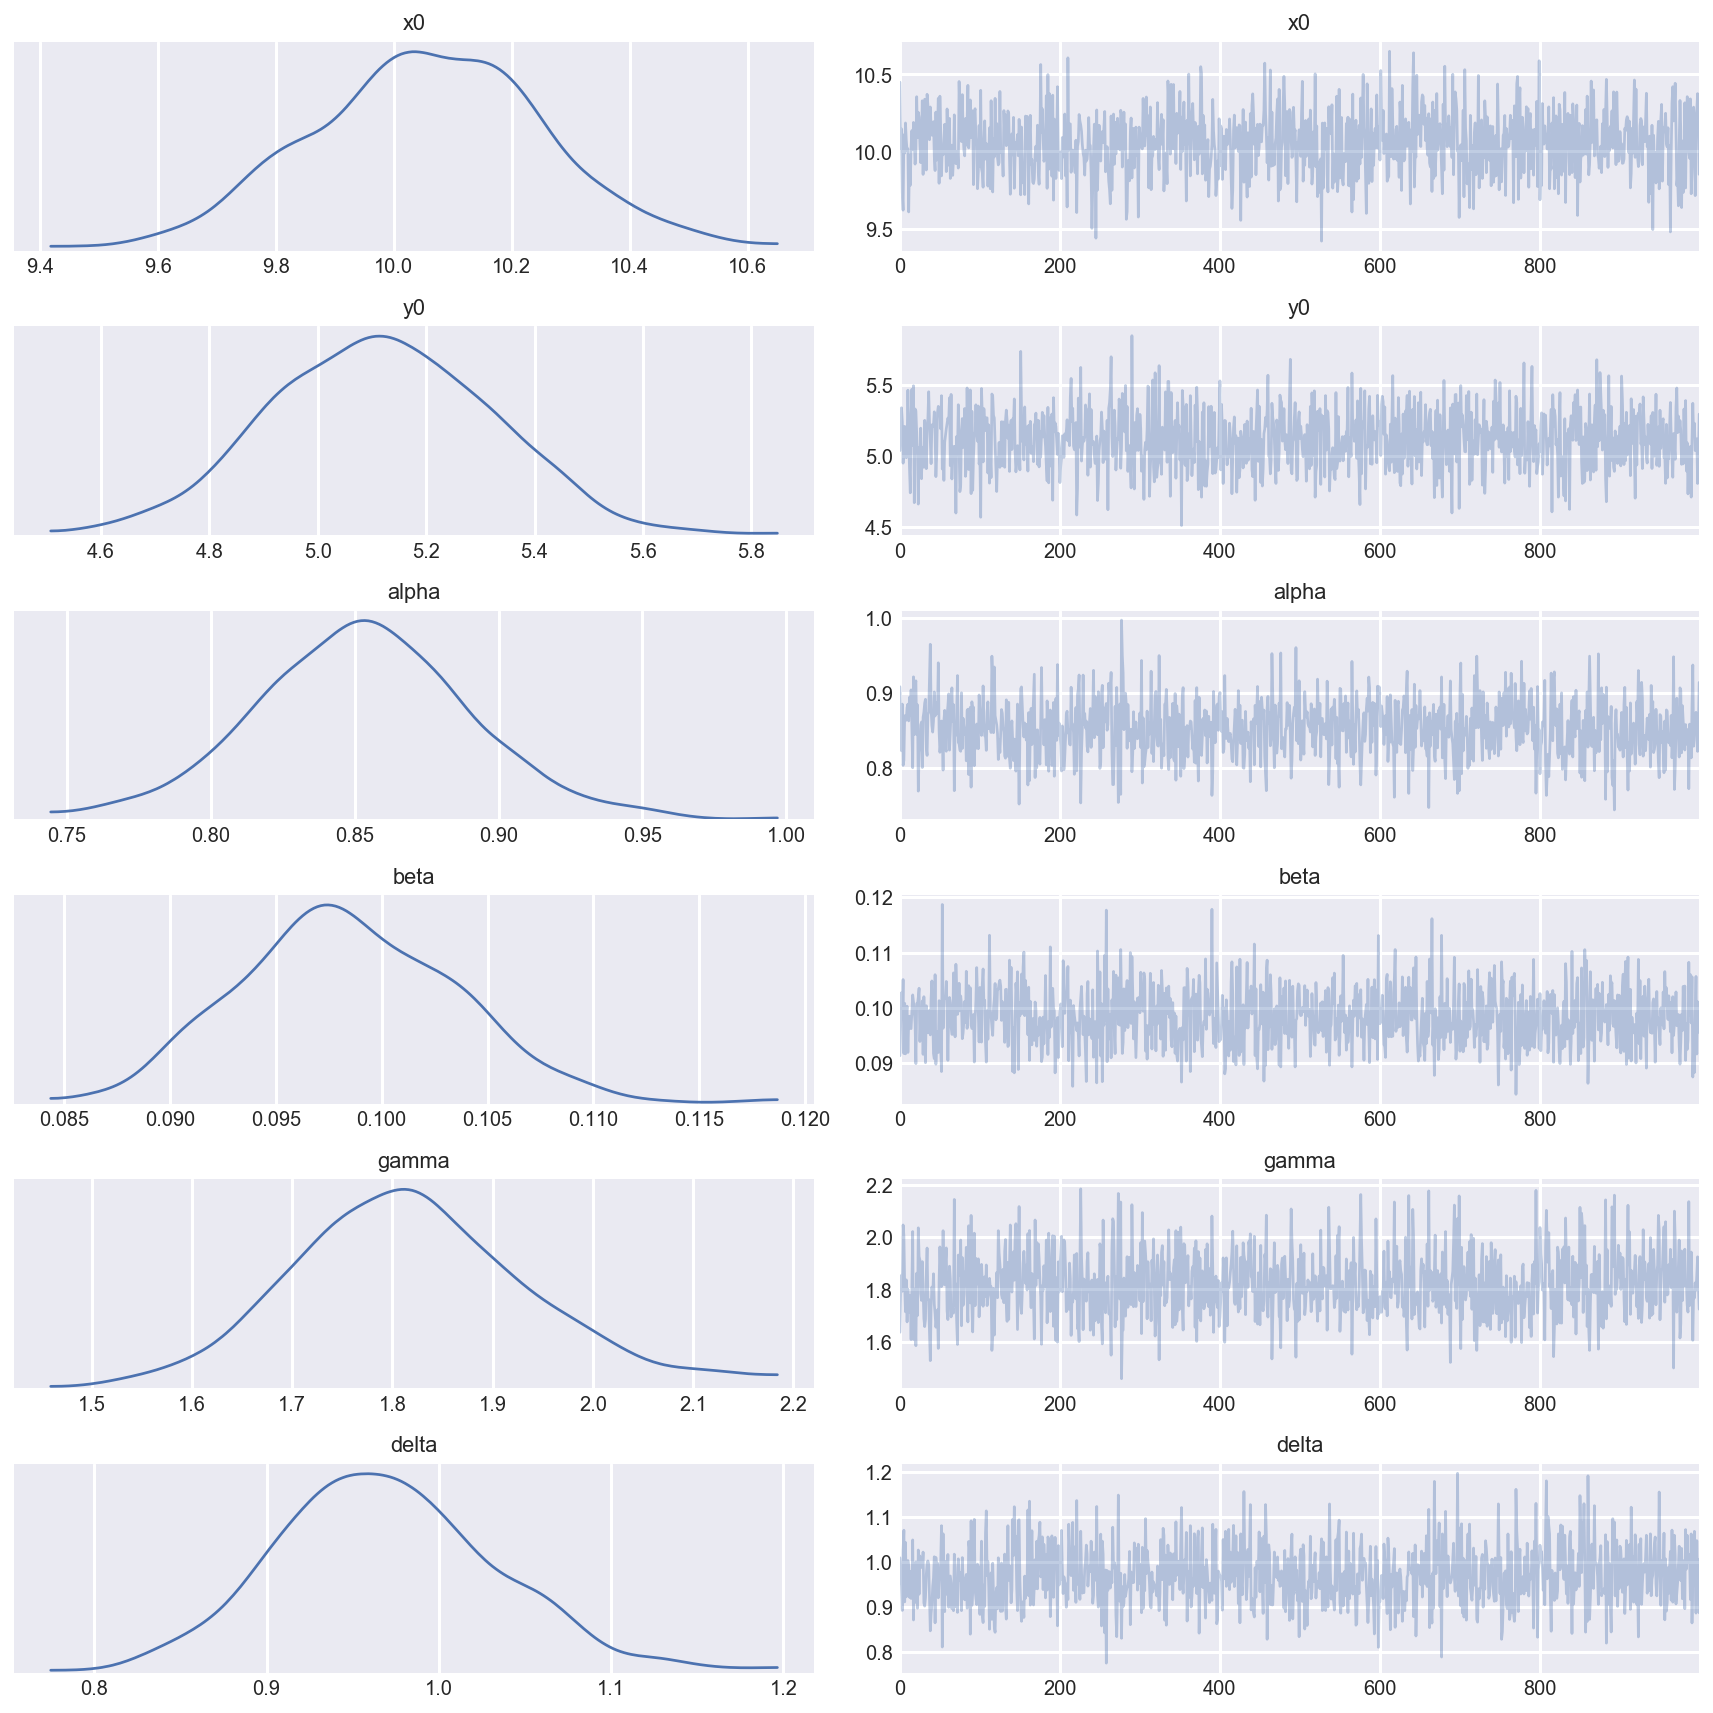

In [0]:
var_name = ['x0', 'y0', 'alpha', 'beta', 'gamma', 'delta']
posterior = {k:v.numpy()[np.newaxis, ...]
             for k, v in zip(var_name, final_state)}

az_trace = az.from_dict(posterior=posterior)
az.plot_trace(az_trace);

In [0]:
posterior_predictive = tf.stack(competition_model(*final_state).states)

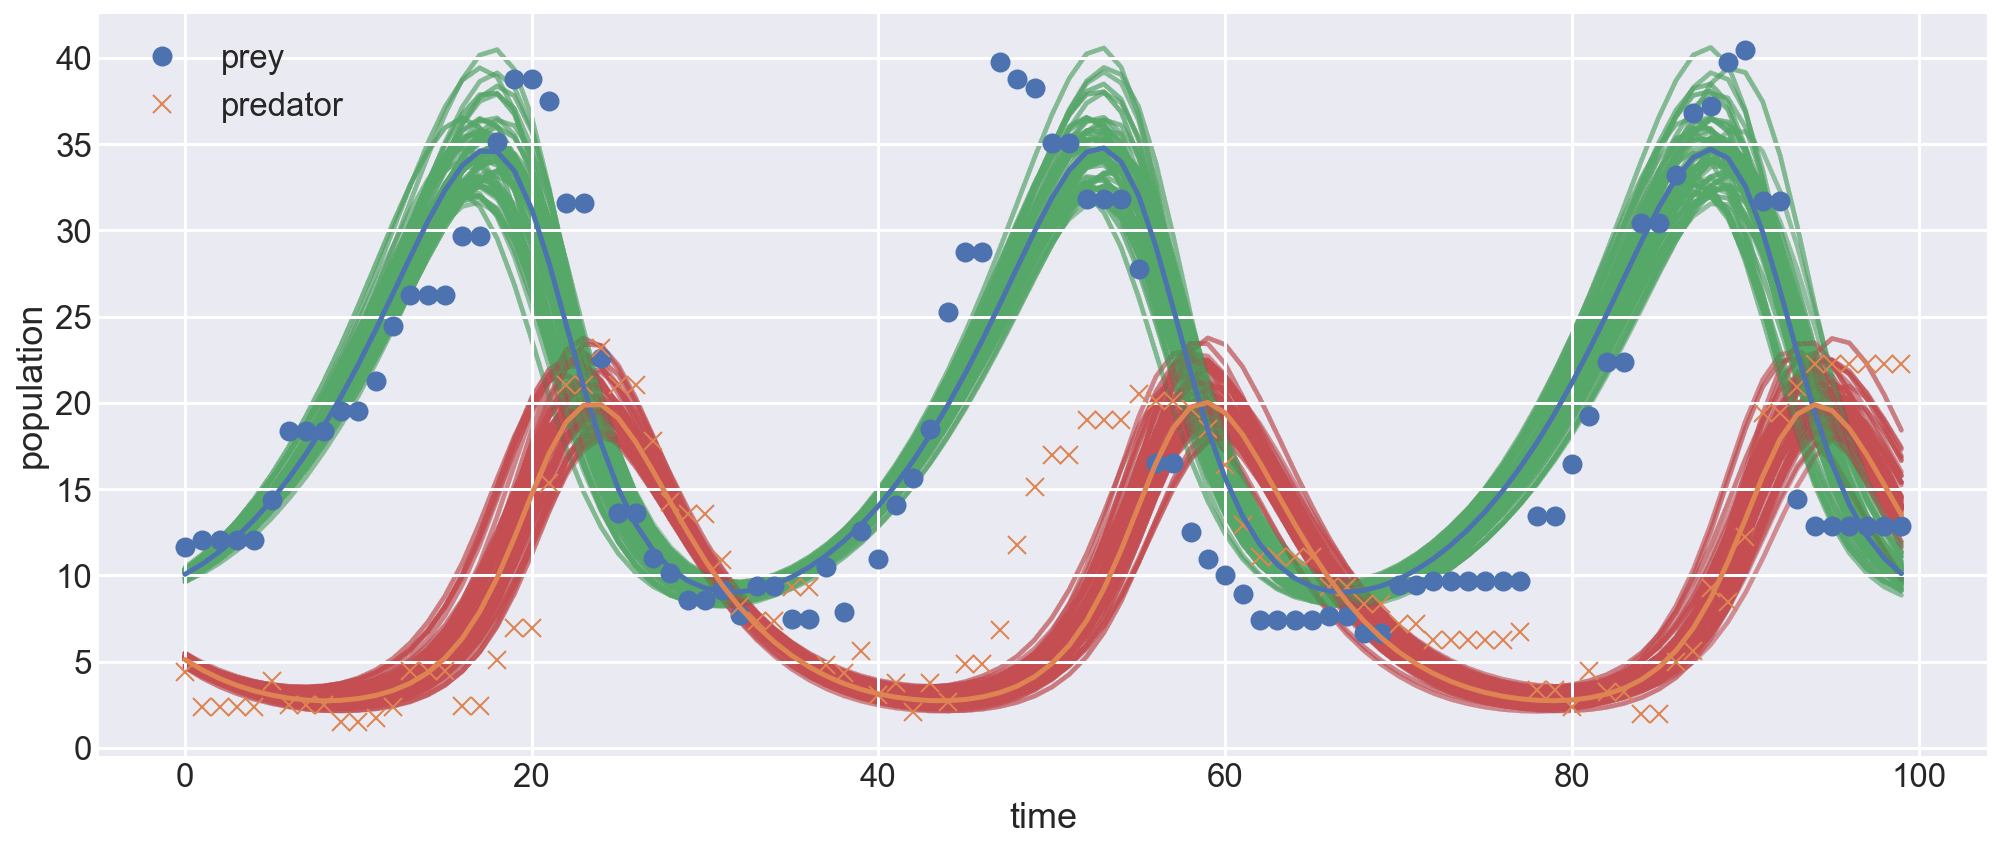

In [0]:
_, ax = plt.subplots(figsize=(14,6))
ax.plot(observed[:, 0], 'o', label='prey', c='C0')
ax.plot(observed[:, 1], 'x', label='predator', c='C1')
ax.plot(tf.transpose(tf.reduce_mean(posterior_predictive, axis=-1)), linewidth=2.5)
for i in np.random.randint(0, 50, 1000):
    ax.plot(posterior_predictive[0, :, i], alpha=0.05, c='C2', zorder=0)
    ax.plot(posterior_predictive[1, :, i], alpha=0.05, c='C3', zorder=0)
ax.set_xlabel('time')
ax.set_ylabel('population')
ax.legend();

## Bayesian State Space Model (BSTS)

https://github.com/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Structural_Time_Series_Modeling_Case_Studies_Atmospheric_CO2_and_Electricity_Demand.ipynb

Update posterior samples conditioned on the new observation.

Here we sampled from the posterior conditioned on the training data set, update the posterior using the test data set, and compare the result with running the inference on the whole data set.

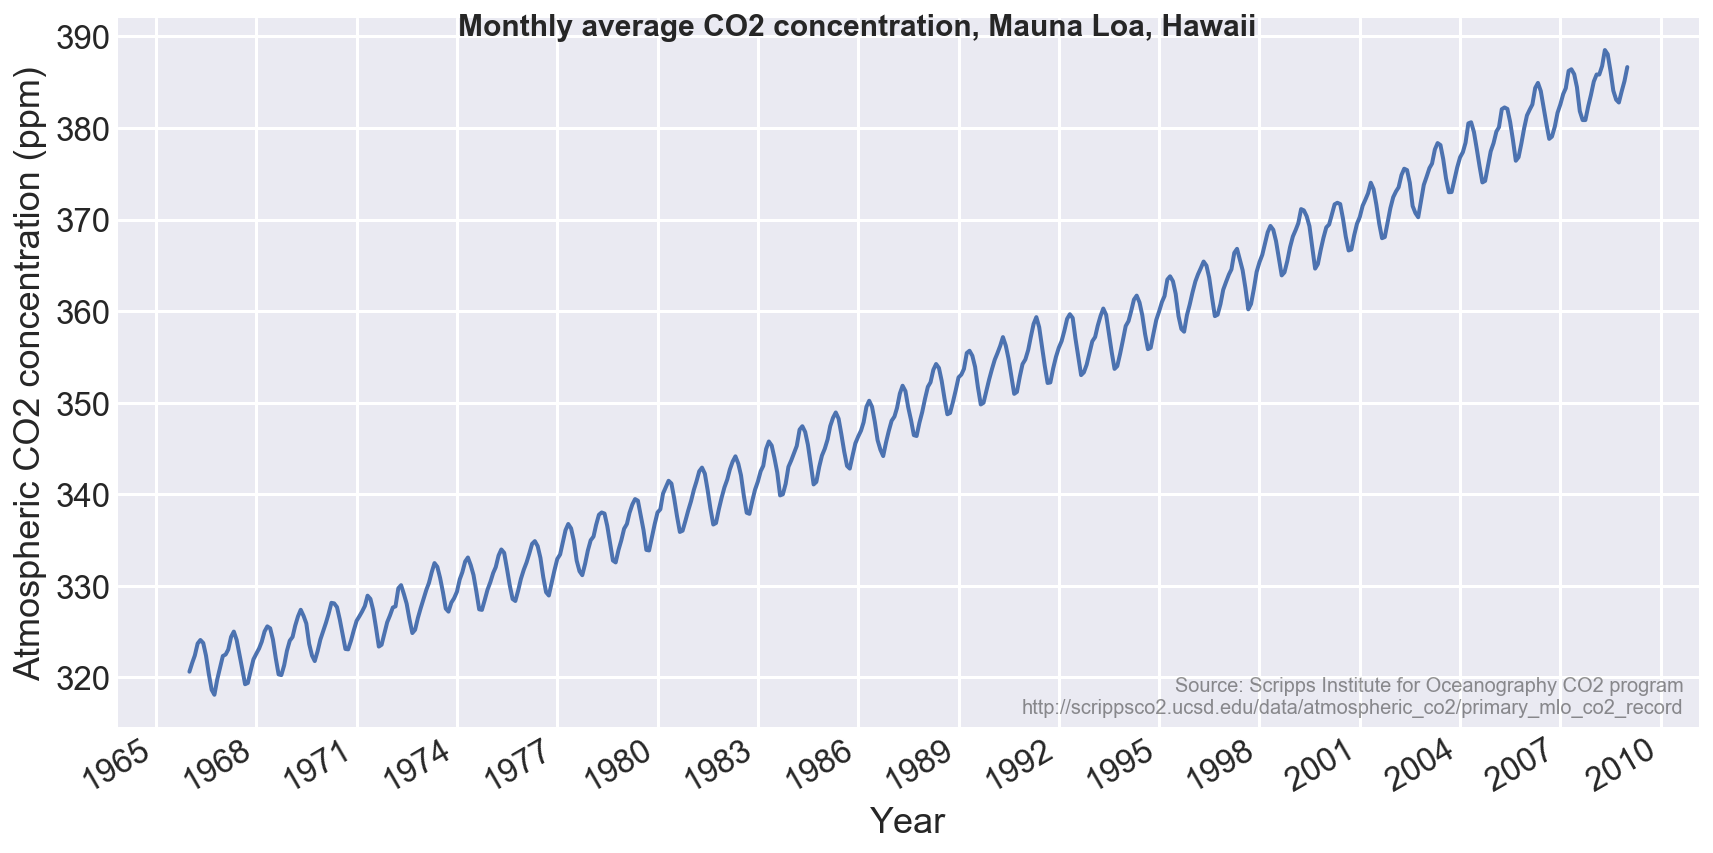

In [0]:
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# CO2 readings from Mauna Loa observatory, monthly beginning January 1966
# Original source: http://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record
co2_by_month = np.array('320.62,321.60,322.39,323.70,324.08,323.75,322.38,320.36,318.64,318.10,319.78,321.03,322.33,322.50,323.04,324.42,325.00,324.09,322.54,320.92,319.25,319.39,320.73,321.96,322.57,323.15,323.89,325.02,325.57,325.36,324.14,322.11,320.33,320.25,321.32,322.89,324.00,324.42,325.63,326.66,327.38,326.71,325.88,323.66,322.38,321.78,322.85,324.12,325.06,325.98,326.93,328.14,328.08,327.67,326.34,324.69,323.10,323.06,324.01,325.13,326.17,326.68,327.17,327.79,328.92,328.57,327.36,325.43,323.36,323.56,324.80,326.01,326.77,327.63,327.75,329.73,330.07,329.09,328.04,326.32,324.84,325.20,326.50,327.55,328.55,329.56,330.30,331.50,332.48,332.07,330.87,329.31,327.51,327.18,328.16,328.64,329.35,330.71,331.48,332.65,333.09,332.25,331.18,329.39,327.43,327.37,328.46,329.57,330.40,331.40,332.04,333.31,333.97,333.60,331.90,330.06,328.56,328.34,329.49,330.76,331.75,332.56,333.50,334.58,334.88,334.33,333.05,330.94,329.30,328.94,330.31,331.68,332.93,333.42,334.70,336.07,336.75,336.27,334.92,332.75,331.59,331.16,332.40,333.85,334.97,335.38,336.64,337.76,338.01,337.89,336.54,334.68,332.76,332.55,333.92,334.95,336.23,336.76,337.96,338.88,339.47,339.29,337.73,336.09,333.92,333.86,335.29,336.73,338.01,338.36,340.07,340.77,341.47,341.17,339.56,337.60,335.88,336.02,337.10,338.21,339.24,340.48,341.38,342.51,342.91,342.25,340.49,338.43,336.69,336.86,338.36,339.61,340.75,341.61,342.70,343.57,344.14,343.35,342.06,339.81,337.98,337.86,339.26,340.49,341.38,342.52,343.10,344.94,345.76,345.32,343.98,342.38,339.87,339.99,341.15,342.99,343.70,344.50,345.28,347.06,347.43,346.80,345.39,343.28,341.07,341.35,342.98,344.22,344.97,345.99,347.42,348.35,348.93,348.25,346.56,344.67,343.09,342.80,344.24,345.56,346.30,346.95,347.85,349.55,350.21,349.55,347.94,345.90,344.85,344.17,345.66,346.90,348.02,348.48,349.42,350.99,351.85,351.26,349.51,348.10,346.45,346.36,347.81,348.96,350.43,351.73,352.22,353.59,354.22,353.79,352.38,350.43,348.73,348.88,350.07,351.34,352.76,353.07,353.68,355.42,355.67,355.12,353.90,351.67,349.80,349.99,351.30,352.52,353.66,354.70,355.38,356.20,357.16,356.23,354.81,352.91,350.96,351.18,352.83,354.21,354.72,355.75,357.16,358.60,359.34,358.24,356.17,354.02,352.15,352.21,353.75,354.99,355.99,356.72,357.81,359.15,359.66,359.25,357.02,355.00,353.01,353.31,354.16,355.40,356.70,357.17,358.38,359.46,360.28,359.60,357.57,355.52,353.69,353.99,355.34,356.80,358.37,358.91,359.97,361.26,361.69,360.94,359.55,357.48,355.84,356.00,357.58,359.04,359.97,361.00,361.64,363.45,363.80,363.26,361.89,359.45,358.05,357.75,359.56,360.70,362.05,363.24,364.02,364.71,365.41,364.97,363.65,361.48,359.45,359.61,360.76,362.33,363.18,363.99,364.56,366.36,366.80,365.63,364.47,362.50,360.19,360.78,362.43,364.28,365.33,366.15,367.31,368.61,369.30,368.88,367.64,365.78,363.90,364.23,365.46,366.97,368.15,368.87,369.59,371.14,371.00,370.35,369.27,366.93,364.64,365.13,366.68,368.00,369.14,369.46,370.51,371.66,371.83,371.69,370.12,368.12,366.62,366.73,368.29,369.53,370.28,371.50,372.12,372.86,374.02,373.31,371.62,369.55,367.96,368.09,369.68,371.24,372.44,373.08,373.52,374.85,375.55,375.40,374.02,371.48,370.70,370.25,372.08,373.78,374.68,375.62,376.11,377.65,378.35,378.13,376.61,374.48,372.98,373.00,374.35,375.69,376.79,377.36,378.39,380.50,380.62,379.55,377.76,375.83,374.05,374.22,375.84,377.44,378.34,379.61,380.08,382.05,382.24,382.08,380.67,378.67,376.42,376.80,378.31,379.96,381.37,382.02,382.56,384.37,384.92,384.03,382.28,380.48,378.81,379.06,380.14,381.66,382.58,383.71,384.34,386.23,386.41,385.87,384.45,381.84,380.86,380.86,382.36,383.61,385.07,385.84,385.83,386.77,388.51,388.05,386.25,384.08,383.09,382.78,384.01,385.11,386.65,387.12,388.52,389.57,390.16,389.62,388.07,386.08,384.65,384.33,386.05,387.49,388.55,390.07,391.01,392.38,393.22,392.24,390.33,388.52,386.84,387.16,388.67,389.81,391.30,391.92,392.45,393.37,394.28,393.69,392.59,390.21,389.00,388.93,390.24,391.80,393.07,393.35,394.36,396.43,396.87,395.88,394.52,392.54,391.13,391.01,392.95,394.34,395.61,396.85,397.26,398.35,399.98,398.87,397.37,395.41,393.39,393.70,395.19,396.82,397.92,398.10,399.47,401.33,401.88,401.31,399.07,397.21,395.40,395.65,397.23,398.79,399.85,400.31,401.51,403.45,404.10,402.88,401.61,399.00,397.50,398.28,400.24,401.89,402.65,404.16,404.85,407.57,407.66,407.00,404.50,402.24,401.01,401.50,403.64,404.55,406.07,406.64,407.06,408.95,409.91,409.12,407.20,405.24,403.27,403.64,405.17,406.75,408.05,408.34,409.25,410.30,411.30,410.88,408.90,407.10,405.59,405.99,408.12,409.23,410.92'.split(',')).astype(np.float32)

co2_by_month = co2_by_month
num_forecast_steps = 12 * 10 # Forecast the final ten years, given previous data
co2_by_month_training_data = co2_by_month[:-num_forecast_steps]
co2_by_month_validation_data = co2_by_month[-num_forecast_steps:-int(num_forecast_steps/2)]
co2_by_month_training_data2 = co2_by_month[:-int(num_forecast_steps/2)]
co2_by_month_test_data = co2_by_month[-int(num_forecast_steps/2):]

co2_dates = np.arange("1966-01", "2019-02", dtype="datetime64[M]")
co2_loc = mdates.YearLocator(3)
co2_fmt = mdates.DateFormatter('%Y')

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(co2_dates[:-num_forecast_steps], co2_by_month_training_data, lw=2, label="training data")
ax.xaxis.set_major_locator(co2_loc)
ax.xaxis.set_major_formatter(co2_fmt)
ax.set_ylabel("Atmospheric CO2 concentration (ppm)")
ax.set_xlabel("Year")
fig.suptitle("Monthly average CO2 concentration, Mauna Loa, Hawaii",
             fontsize=15)
ax.text(0.99, .02,
        "Source: Scripps Institute for Oceanography CO2 program\nhttp://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record",
        transform=ax.transAxes,
        horizontalalignment="right",
        alpha=0.5)
fig.autofmt_xdate()

In [0]:
def build_model(observed_time_series):
  trend = tfp.sts.LocalLinearTrend(observed_time_series=observed_time_series)
  seasonal = tfp.sts.Seasonal(
      num_seasons=12, observed_time_series=observed_time_series)
  model = tfp.sts.Sum([trend, seasonal], observed_time_series=observed_time_series)
  return model

In [0]:
co2_model = build_model(co2_by_month_training_data)

# Build the variational surrogate posteriors `qs`.
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(
    model=co2_model)

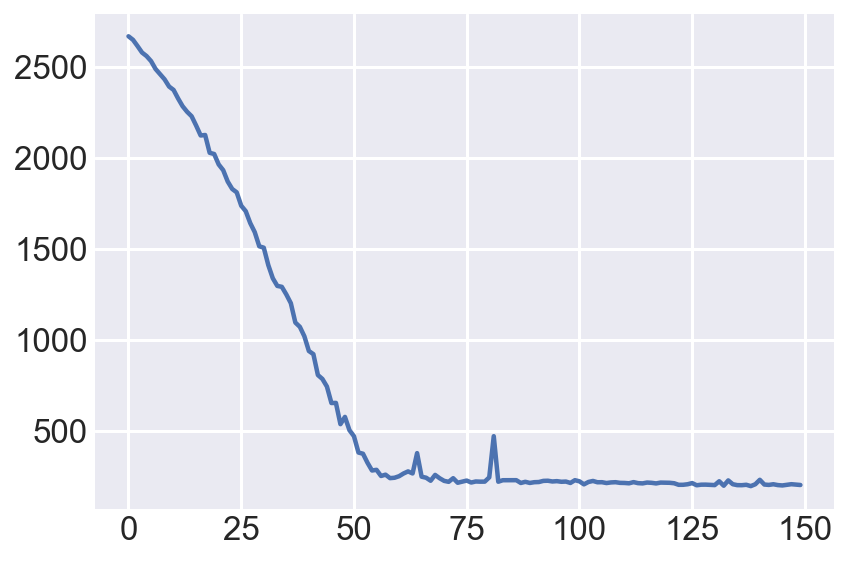

In [0]:
#@title Minimize the variational loss.

# Allow external control of optimization to reduce test runtimes.
num_variational_steps = 150 # @param { isTemplate: true}
num_variational_steps = int(num_variational_steps)

optimizer = tf.optimizers.Adam(learning_rate=.1)
# Using fit_surrogate_posterior to build and optimize the variational loss function.
@tf.function(experimental_compile=True)
def train():
  elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=co2_model.joint_log_prob(
        observed_time_series=co2_by_month_training_data),
    surrogate_posterior=variational_posteriors,
    optimizer=optimizer,
    num_steps=num_variational_steps)
  return elbo_loss_curve

elbo_loss_curve = train()

plt.plot(elbo_loss_curve)
plt.show()

# Draw samples from the variational posterior.
q_samples_co2_ = variational_posteriors.sample(50)

In [0]:
print("Inferred parameters:")
for param in co2_model.parameters:
  print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples_co2_[param.name], axis=0),
                              np.std(q_samples_co2_[param.name], axis=0)))

Inferred parameters:
observation_noise_scale: 0.18043218553066254 +- 0.009829692542552948
LocalLinearTrend/_level_scale: 0.19318145513534546 +- 0.045561667531728745
LocalLinearTrend/_slope_scale: 0.012759692966938019 +- 0.0033203463535755873
Seasonal/_drift_scale: 0.04335853457450867 +- 0.007470848970115185


In [0]:
#@title MCMC (very slow)
%%time
Run_MCMC = False #@param {type:"boolean"}
if Run_MCMC:
  posterior_sample = variational_posteriors.sample(10)
  initial_state = [posterior_sample[p.name] for p in co2_model.parameters]

  q_dists_by_name, _ = variational_posteriors.sample_distributions()
  initial_step_size = [
    q_dists_by_name[p.name].distribution.stddev()
    for p in co2_model.parameters]

  num_results = 100
  num_warmup_steps = 50
  num_leapfrog_steps = 15

  observed_time_series = sts_util.pad_batch_dimension_for_multiple_chains(
      co2_by_month_training_data, co2_model, chain_batch_shape=10)
  target_log_prob_fn = co2_model.joint_log_prob(observed_time_series)

  # Run HMC to sample from the posterior on parameters.
  @tf.function(
      input_signature=[tf.TensorSpec([], dtype=tf.int32),
                       tf.TensorSpec([], dtype=tf.int32)],
      autograph=False,
      experimental_compile=True)
  def run_hmc(num_results=100, num_warmup_steps=50):
    return tfp.mcmc.sample_chain(
        num_results=num_results,
        current_state=initial_state,
        num_burnin_steps=num_warmup_steps,
        kernel=tfp.mcmc.DualAveragingStepSizeAdaptation(
            inner_kernel=tfp.mcmc.TransformedTransitionKernel(
                inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
                    target_log_prob_fn=target_log_prob_fn,
                    step_size=initial_step_size,
                    num_leapfrog_steps=num_leapfrog_steps,
                    state_gradients_are_stopped=True),
                bijector=[param.bijector for param in co2_model.parameters]),
            num_adaptation_steps=num_warmup_steps),
        trace_fn=None
        )

  _ = run_hmc(1, 1)
  print('XLA compile done.')
  samples = run_hmc()

CPU times: user 29 µs, sys: 0 ns, total: 29 µs
Wall time: 58.4 µs


### Conditioned on validation set

In [0]:
samples = variational_posteriors.sample(10)
new_conditional_logp = co2_model.joint_log_prob(co2_by_month_validation_data)

new_conditional_logp(**samples)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-86.03932 , -87.17283 , -87.00027 , -86.15093 , -87.85797 ,
       -86.572815, -86.07371 , -86.46353 , -85.63218 , -86.07995 ],
      dtype=float32)>

In [0]:
from tensorflow_probability.python.internal import distribution_util
from tensorflow_probability.python.sts.internal import util as sts_util

def prior_log_prob_fn(*param_vals):
  return sum([
      param.prior.log_prob(param_val)
      for (param, param_val) in zip(co2_model.parameters, 
                                    param_vals)
  ])

[
    observed_time_series_,
    mask
] = sts_util.canonicalize_observed_time_series_with_mask(
    co2_by_month_validation_data)

num_timesteps = distribution_util.prefer_static_value(
    tf.shape(observed_time_series_))[-2]

def likelihood_log_prob_fn(*param_vals):
  # Build a linear Gaussian state space model and evaluate the marginal
  # log_prob on observations.
  lgssm = co2_model.make_state_space_model(
      param_vals=param_vals, num_timesteps=num_timesteps)
  observation_lp = lgssm.log_prob(observed_time_series_,
                                  mask=mask)
  return observation_lp

likelihood_log_prob_fn(*samples.values()) + prior_log_prob_fn(*samples.values())

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-86.03932 , -87.17283 , -87.00027 , -86.15093 , -87.85797 ,
       -86.572815, -86.07371 , -86.46353 , -85.63218 , -86.07995 ],
      dtype=float32)>

In [0]:
samples = variational_posteriors.sample(1000)
init_state = list(samples.values())

_make_transform_hmc_kernel_fn = gen_make_transform_hmc_kernel_fn(
    [param.bijector for param in co2_model.parameters],
    num_leapfrog_steps=5)

@tf.function(experimental_compile=True)
def run_smc():
  (
      n_stage, final_state, final_kernel_results
  ) = sample_sequential_monte_carlo_chain(
    prior_log_prob_fn,
    likelihood_log_prob_fn,
    init_state,
    make_kernel_fn=_make_transform_hmc_kernel_fn,
    tuning_fn=simple_heuristic_tuning_hmc,
    max_num_steps=50
    )
  return n_stage, final_state, final_kernel_results

n_stage, final_state, final_kernel_results = run_smc()

Comparing with using yesterday's (Variational) posterior as today's prior.

In [0]:
@tf.function(experimental_compile=True)
def run_smc_():
  (
      n_stage, final_state, final_kernel_results
  ) = sample_sequential_monte_carlo_chain(
    variational_posteriors.log_prob,
    likelihood_log_prob_fn,
    init_state,
    make_kernel_fn=_make_transform_hmc_kernel_fn,
    tuning_fn=simple_heuristic_tuning_hmc,
    max_num_steps=50
    )
  return n_stage, final_state, final_kernel_results

n_stage, final_state_, final_kernel_results = run_smc_()

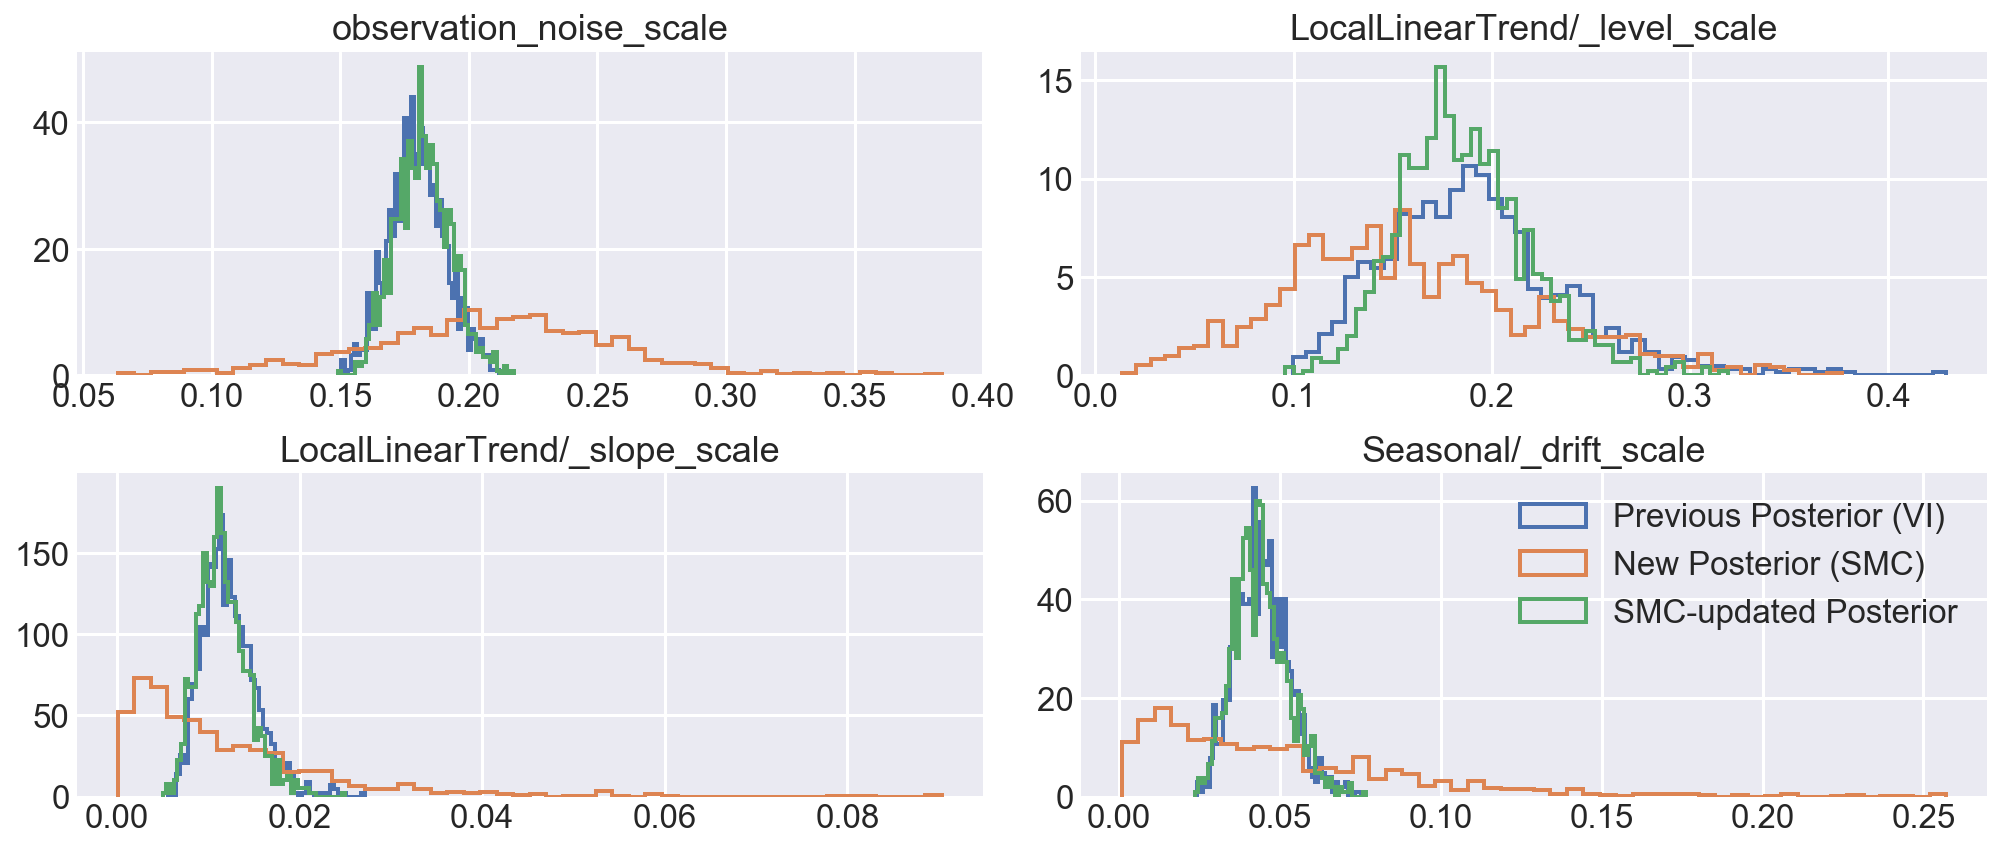

In [0]:
_, ax = plt.subplots(2, 2, figsize=(14, 6))
ax = ax.flatten()
for i, param in enumerate(co2_model.parameters):
  ax[i].hist(init_state[i], bins=50,
             density=True, histtype='step', lw=2, label='Previous Posterior (VI)')
  ax[i].hist(final_state[i], bins=50,
             density=True, histtype='step', lw=2, label='New Posterior (SMC)')
  ax[i].hist(final_state_[i], bins=50,
             density=True, histtype='step', lw=2, label='SMC-updated Posterior')
  # ax[i].hist(param.prior.sample(1000), bins=50,
  #            density=True, histtype='step', lw=2, label='Latent Truth')
  ax[i].set_title(param.name)
plt.legend();
plt.tight_layout();

### Forecasting conditioned on the newest observed

In [0]:
import collections

posterior_samples = collections.OrderedDict()
for key, values in zip(
    q_samples_co2_.keys(),
    # init_state
    # final_state
    final_state_
    ):
  posterior_samples[key] = values

In [0]:
co2_model_ = build_model(co2_by_month_validation_data)

co2_forecast_dist = tfp.sts.forecast(
    co2_model_,
    observed_time_series=co2_by_month_validation_data,
    parameter_samples=posterior_samples,
    num_steps_forecast=num_forecast_steps // 2)

In [0]:
num_samples = 20

co2_forecast_mean, co2_forecast_scale, co2_forecast_samples = (
    co2_forecast_dist.mean().numpy()[..., 0],
    co2_forecast_dist.stddev().numpy()[..., 0],
    co2_forecast_dist.sample(num_samples).numpy()[..., 0])

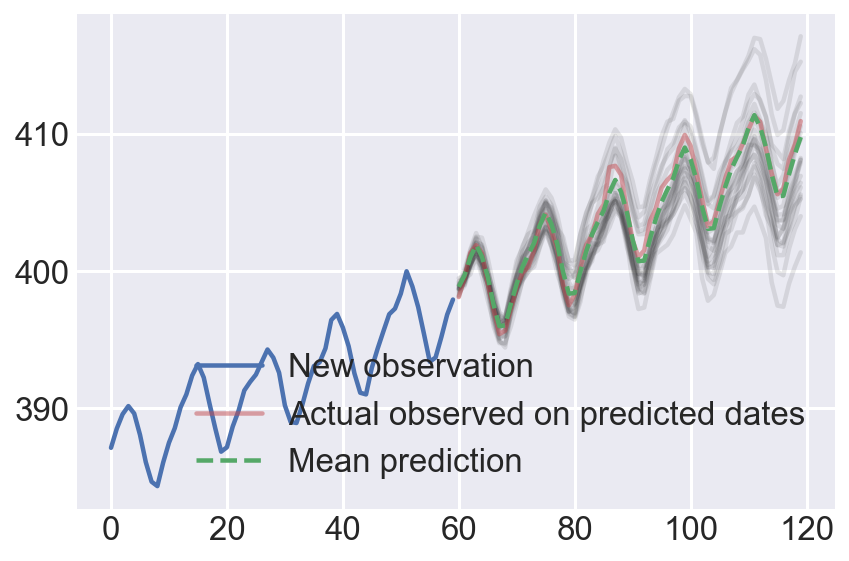

In [0]:
n1 = len(co2_by_month_validation_data)
n2 = len(co2_by_month_test_data)
plt.plot(np.arange(n1),
         co2_by_month_validation_data,
         label='New observation')
plt.plot(np.arange(n1, n1+n2),
         tf.transpose(co2_forecast_samples), 
         color='k',
         alpha=.1)
plt.plot(np.arange(n1, n1+n2),
         co2_by_month_test_data,
         color='r',
         alpha=.5,
         label='Actual observed on predicted dates')
plt.plot(np.arange(n1, n1+n2),
         co2_forecast_mean, 
         '--g',
         label='Mean prediction')
plt.legend();

# Follow ups



*   Other transitional kernel from https://arxiv.org/pdf/1903.04797.pdf
*   Using similar amortization and temperature annealing for VI (e.g., Stein Variational Gradient Descent)

